<a href="https://colab.research.google.com/github/AceroMike/Big-Data/blob/main/Predicting_Airbnb_Prices_in_New_York_using_Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installations

!pip install dask[complete] --quiet
!pip install dask distributed --upgrade --quiet
!pip install aiohttp --quiet
!pip install dask-ml --quiet

     |████████████████████████████████| 112kB 5.5MB/s 
     |████████████████████████████████| 675kB 8.0MB/s 
ERROR: distributed 2021.3.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.3.0 has requirement dask>=2021.03.0, but you'll have dask 2.12.0 which is incompatible.
     |████████████████████████████████| 931kB 6.8MB/s 
     |████████████████████████████████| 1.3MB 6.5MB/s 
     |████████████████████████████████| 143kB 39.2MB/s 
     |████████████████████████████████| 296kB 34.3MB/s 
     |████████████████████████████████| 143kB 7.2MB/s 
     |████████████████████████████████| 22.3MB 1.9MB/s 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

#Dask 
import dask.bag as db
import dask.dataframe as dd
import dask.array as da
from dask import delayed
from dask.distributed import Client, progress
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LinearRegression

#Sklearn
#from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate, GridSearchCV

import joblib


#Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error

In [ ]:
#import numpy as np
#import pandas as pd
#import seaborn as sns
#from sklearn import linear_model
#import matplotlib.pyplot as plt
##from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.linear_model import LinearRegression
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#from statsmodels.tools.eval_measures import mse, rmse
#from sklearn.metrics import mean_absolute_error

The purpose of this analysis is to predict prices for Airbnbs in New York. While I will be predicting prices I will be relying on interpretive models to understand the most important factors of prices. The data from this analysis comes from [Inside Airbnb](http://insideairbnb.com/get-the-data.html)

For this analysis I will first train a model on prices without removing outliers. I will compare Regression models and explain limitations on predicitons due to the outliers. 

Next, I will predict prices for Airbnb listings with prices less than (prices <= $300). Then I will compare how well the best interprative model (Regression Model) compares to price predictions using Random Forest Models. With Random Forest Models we may predict prices better, but the results will not be interpretable. 

**EDA:** 

First, to load the data set

In [47]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit='2GB')
client

<Client: 'tcp://127.0.0.1:42885' processes=4 threads=8, memory=8.00 GB>

In [5]:
#Dask Dataframe
df = dd.read_csv('AB_NYC_2019.csv')
df.head(10)

id  ... availability_365
0  2539  ...              365
1  2595  ...              355
2  3647  ...              365
3  3831  ...              194
4  5022  ...                0
5  5099  ...              129
6  5121  ...                0
7  5178  ...              220
8  5203  ...                0
9  5238  ...              188

[10 rows x 16 columns]

Before any data cleaning, our data has 16 features and 48894 observations. Here is a description of each of the features:



*   `id` Listing id number
*   `name`  Name of the listing
*   `host id` Host id number
*   `host name` Name of the host
*   `neighborhood group` Main location
*   `neighborhood` The neighborhood within neighborhood group
*   `latitude` `longitude`
*   `price` Price of the listing (our target)
*   `minimum nights` The minimum amount of nights required to book
*   `number of reviews`
*   `last review` the date of the most recent review
*   `reviews per month` 
*   `calculated host listings count` Amount of listing per host
*   `availibility 365` Amount of days available in the year

Before continuing there are already some columns of data that we can remove from this analysis. We will be dropping the following columns

`id` `name` `host id` `hostname` `latitude` `longitude` 

These features are too specific. For each observation, it is very likely that these variables differ. 


In [8]:
df1 = df.copy()
df1 = df1.drop(['id', 'name', 'host_id', 'host_name', 'latitude', 'longitude'], axis=1)
df1.head()

neighbourhood_group  ... availability_365
0            Brooklyn  ...              365
1           Manhattan  ...              355
2           Manhattan  ...              365
3            Brooklyn  ...              194
4           Manhattan  ...                0

[5 rows x 10 columns]

We see that we have two columns with missing information: `last_review` and `reviews_per_month` We can either remove this data or fill in the values in a meaningful way. Let's take a closer look at each variable first. 

**`last review`**

In [9]:
df1['last_review'].head(10)

0    2018-10-19
1    2019-05-21
2           NaN
3    2019-07-05
4    2018-11-19
5    2019-06-22
6    2017-10-05
7    2019-06-24
8    2017-07-21
9    2019-06-09
Name: last_review, dtype: object

In our analysis, `last review` is a categorical variable. 
Unique cases: 

In [11]:
df1['last_review'].value_counts().compute()

2019-06-23    1413
2019-07-01    1359
2019-06-30    1341
2019-06-24     875
2019-07-07     718
              ... 
2014-10-13       1
2014-10-11       1
2014-10-08       1
2014-10-06       1
2011-03-28       1
Name: last_review, Length: 1764, dtype: int64

There are 1764 unique dates in the data set. This variable will be dropped from the analysis. 

In [14]:
df1 = df1.drop(['last_review'], axis=1)
df1.head()

neighbourhood_group  ... availability_365
0            Brooklyn  ...              365
1           Manhattan  ...              355
2           Manhattan  ...              365
3            Brooklyn  ...              194
4           Manhattan  ...                0

[5 rows x 9 columns]

**`reviews per month`**

In [15]:
df1['reviews_per_month'].head(10)

0    0.21
1    0.38
2     NaN
3    4.64
4    0.10
5    0.59
6    0.40
7    3.47
8    0.99
9    1.33
Name: reviews_per_month, dtype: float64

In [17]:
import matplotlib.pyplot as plt

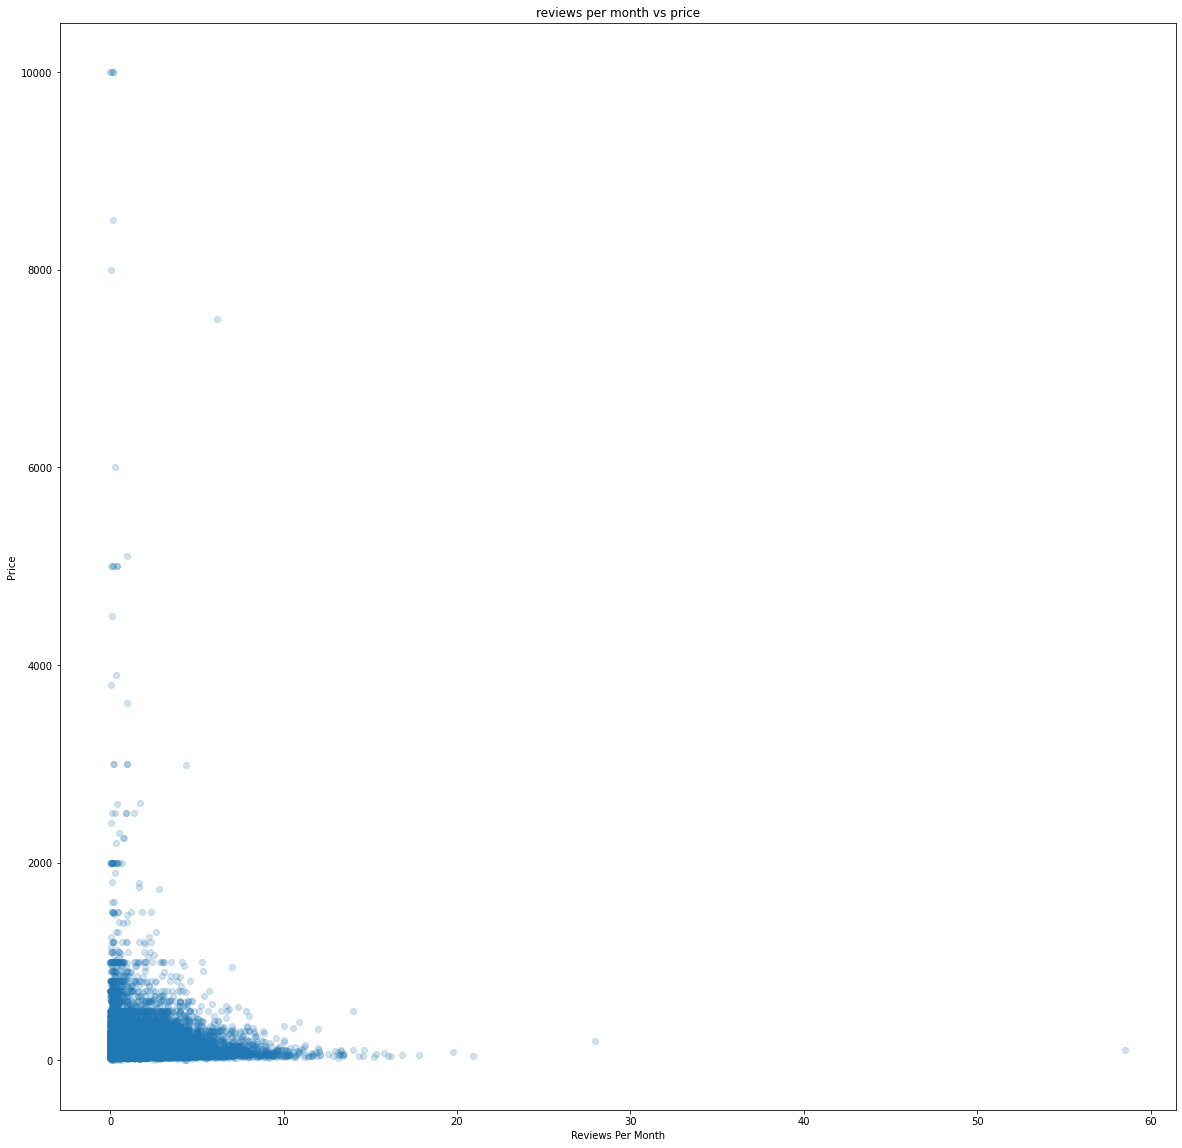

In [20]:
#Plotting Review Per Month and Price
plt.figure(figsize=(20,20))
plt.scatter(df1["reviews_per_month"].compute(), df1["price"].compute(), alpha=0.2)
plt.title("reviews per month vs price")
plt.xlabel("Reviews Per Month")
plt.ylabel("Price")
plt.show()

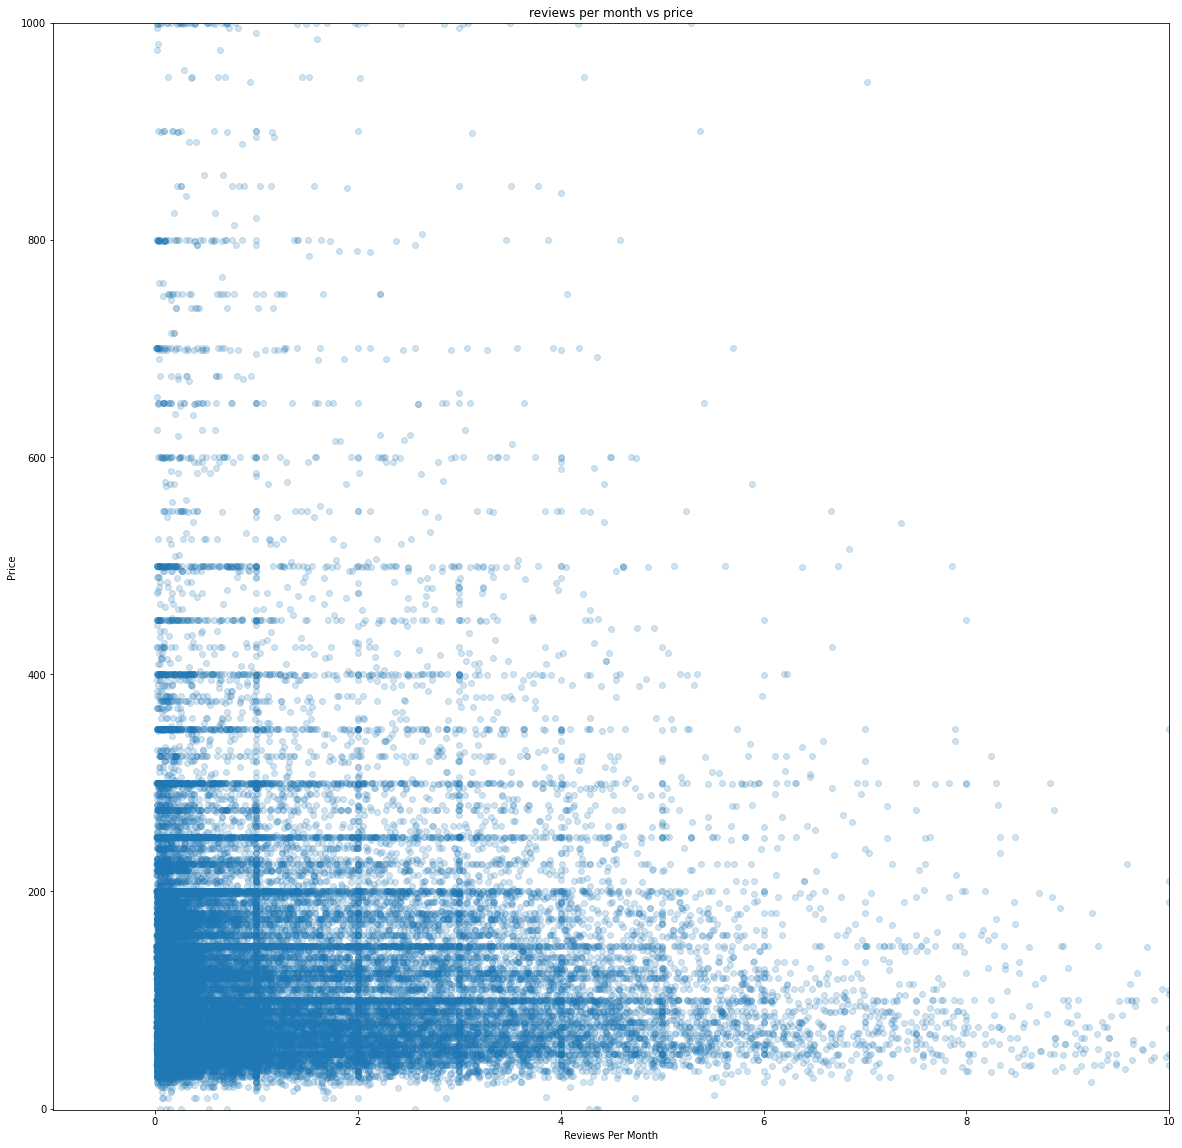

In [23]:
# Zooming in to ignore outliers
plt.figure(figsize=(20,20))
plt.scatter(df1["reviews_per_month"].compute(), df1["price"].compute(), alpha=0.2)
plt.xlim(-1,10)
plt.ylim(-1,1000)
plt.title("reviews per month vs price")
plt.xlabel("Reviews Per Month")
plt.ylabel("Price")
plt.show()

The data for reviews per month is skewed.

In [25]:
df1['reviews_per_month'].describe().compute()

count    38843.000000
mean         1.373221
std          1.680442
min          0.010000
25%          0.190000
50%          0.720000
75%          2.020000
max         58.500000
Name: reviews_per_month, dtype: float64

The data shows that 75% of our observations have a value of reviews per month less than about 2. and 50% is below 0.72. 

In [26]:
df1.corr().compute()

price  ...  availability_365
price                           1.000000  ...          0.081829
minimum_nights                  0.042799  ...          0.144303
number_of_reviews              -0.047954  ...          0.172028
reviews_per_month              -0.030608  ...          0.185791
calculated_host_listings_count  0.057472  ...          0.225701
availability_365                0.081829  ...          1.000000

[6 rows x 6 columns]

In [27]:
df1 = df1.drop(['reviews_per_month'], axis=1)
df1.head(10)

neighbourhood_group  ... availability_365
0            Brooklyn  ...              365
1           Manhattan  ...              355
2           Manhattan  ...              365
3            Brooklyn  ...              194
4           Manhattan  ...                0
5           Manhattan  ...              129
6            Brooklyn  ...                0
7           Manhattan  ...              220
8           Manhattan  ...                0
9           Manhattan  ...              188

[10 rows x 8 columns]

The correlation between reviews per month is the smallest in magnitude with price. We will drop reviews per month. We see that there are other values that do not seem correlated with price, however, we may still find a way to feature engineer these variables.

Now we can begin to take a closer look at our features and finding ways to engineer them so that we explain as much variation in prices as possible. We will first conduct the analysis before removing outliers, then we will remove outliers to see how our results improve. 

**Data Exploration (Before removing outliers):**

First let's take a look at some overall descriptive statistics for our varaibles. 

In [28]:
df1.corr().compute()

price  ...  availability_365
price                           1.000000  ...          0.081829
minimum_nights                  0.042799  ...          0.144303
number_of_reviews              -0.047954  ...          0.172028
calculated_host_listings_count  0.057472  ...          0.225701
availability_365                0.081829  ...          1.000000

[5 rows x 5 columns]

In [29]:
# Numeric Variables
df1.describe().compute()

price  ...  availability_365
count  48895.000000  ...      48895.000000
mean     152.720687  ...        112.781327
std      240.154170  ...        131.622289
min        0.000000  ...          0.000000
25%       69.000000  ...          0.000000
50%      106.000000  ...         45.000000
75%      175.000000  ...        227.000000
max    10000.000000  ...        365.000000

[8 rows x 5 columns]

While we do not see many strong correlations, it may be the case that we will have to treat some numeric variables as categorical. 

*   `price` We will drop values where price is equal to 0. As we saw earlier, there are quite a few high end price outliers. However they may still be able to be explained by the data. We will have a better understanding after we explore the data further and begin to visualize it more. Maybe it is the case that these higher prices correspond to the high values of minimum nights or another variables. If that is the case. Our model may still be able to predict these. 

*   `minimum nights` This column we can spot some obvious outliers. our mean here lies above our 75th percentile which is likely do to the extreme oultiers in the data. Apparently, for one of the observations, the minimum nights required to book is 1250, which feels more like a lease than an Airbnb. Most 5 minimum nights fall within 5 minimum nights. If we include only listings with minimum nights less than or equal to 5 then we can easily treat this variable as categorical. When removing outliers this may be a way we do this. 

*   `number of reviews` 50% of the listings at most 5 reviews. The listing with most reviews has 629 reviews, We may want to exclude these more extreme outliers from the data. Our mean falls very close to our 75 percentile so we can see that the outliers have a strong impact on our mean

*  `calculated host listings counts` The data tells us that most host have either 1 or 2 listings available. This is another variable that we can treat as categorical.

* `availibility 365` 50% of the data has availibity of 0 days.






In [30]:
# Categorical Variables
df1.describe(include=['O']).compute()

neighbourhood_group neighbourhood        room_type
unique                   5           221                3
count                48895         48895            48895
top              Manhattan  Williamsburg  Entire home/apt
freq                 21661          3920            25409

I believe we will learn a lot more from our categorical variables in the model. The neighborhood of the Airbnb is likely to affect the price since some parts of New York are more expensive then others. Room type will also be an important indicator of price. 

*   `neighborhood group` There are 5 distinct New York City. Listings in Manhattan makes up about 45% of all listings. 

*   `neighborhood` There are 221 unique neighborhoods. We will want to find a way of grouping them in a way that shows variation in price and reduces the amount of features. The most common neighborhood is Williamsburg. 

Now to study our data a bit closer: 

**Numeric Variables Univariate Analysis:**



**Price:**

In [31]:
df1['price'].value_counts().compute()

100    2051
150    2047
50     1534
60     1458
200    1401
       ... 
362       1
805       1
814       1
820       1
888       1
Name: price, Length: 674, dtype: int64

In [32]:
df1[df1['price'] == 0].count().compute()

neighbourhood_group               11
neighbourhood                     11
room_type                         11
price                             11
minimum_nights                    11
number_of_reviews                 11
calculated_host_listings_count    11
availability_365                  11
dtype: int64

Earlier we saw that we had some prices at price 0. We will want to remove those from the data set. Fortunately, we see that a price of 0 is not a very common price so we will not be losing a lot of data. Now we will drop all observations with a price of 0.

In [33]:
# Dropping observations with price of 0
df1 = df1[df1['price'] != 0]
df1.head(10)

neighbourhood_group  ... availability_365
0            Brooklyn  ...              365
1           Manhattan  ...              355
2           Manhattan  ...              365
3            Brooklyn  ...              194
4           Manhattan  ...                0
5           Manhattan  ...              129
6            Brooklyn  ...                0
7           Manhattan  ...              220
8           Manhattan  ...                0
9           Manhattan  ...              188

[10 rows x 8 columns]

In [35]:
df1['price'].describe().compute()

count    48884.000000
mean       152.755053
std        240.170260
min         10.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

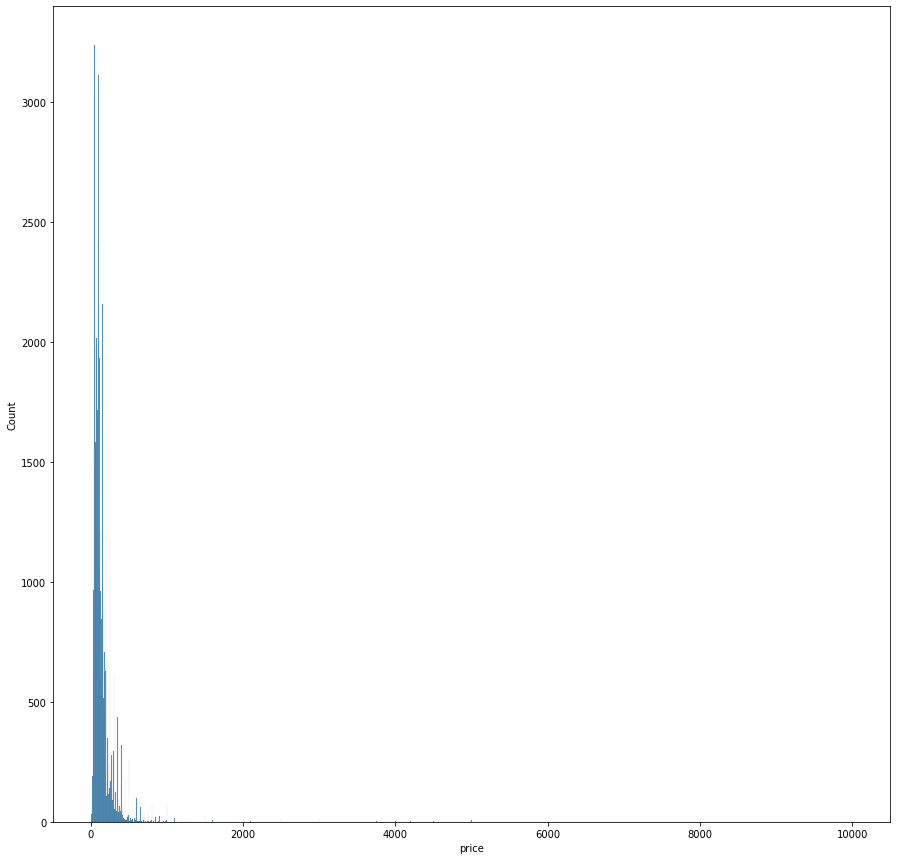

In [36]:
plt.figure(figsize=(15,15))
sns.histplot(df1['price'].compute())
plt.show()

The Data is skewed. We want a better look of the data by ignoring the outliers

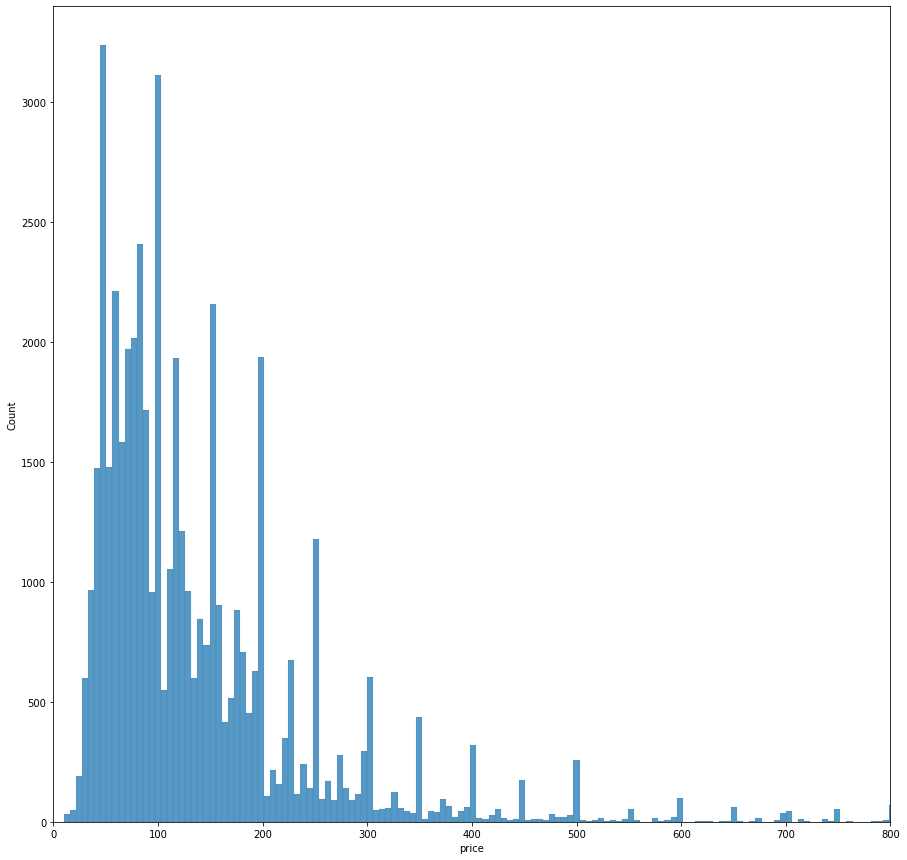

In [37]:
plt.figure(figsize=(15,15))
sns.histplot(df1['price'].compute())
plt.xlim(0,800)
plt.show()

In [38]:
df1['price'].describe().compute()

count    48884.000000
mean       152.755053
std        240.170260
min         10.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

We see that our data is skewed to the left. This is because most (75%) of the listings in the data cost at most $175. We will later log transform the varaible but the interpretation will change. We will no longer be predicting price itself but the log transform of price. Still, the results are interpretable and log transforming price will improve the predictions. 

**Minimum Nights:**

In [39]:
df1['minimum_nights'].value_counts().compute()

1      12717
2      11693
3       7998
30      3758
4       3302
       ...  
122        1
134        1
153        1
175        1
74         1
Name: minimum_nights, Length: 109, dtype: int64

Most listings are for a few nights (1-4) nights. This makes up about 74% of the data. We also see that month long leases are also pretty common making up about 8% of the data. (Together, they make up about 82%) of the data. There are 109 unique values for minimum nights but the remaining 104 values make up a small fraction of the data. We will feature engineer this variable into a categorical variable, we will be grouping the data into groups that show significant variation in prices.



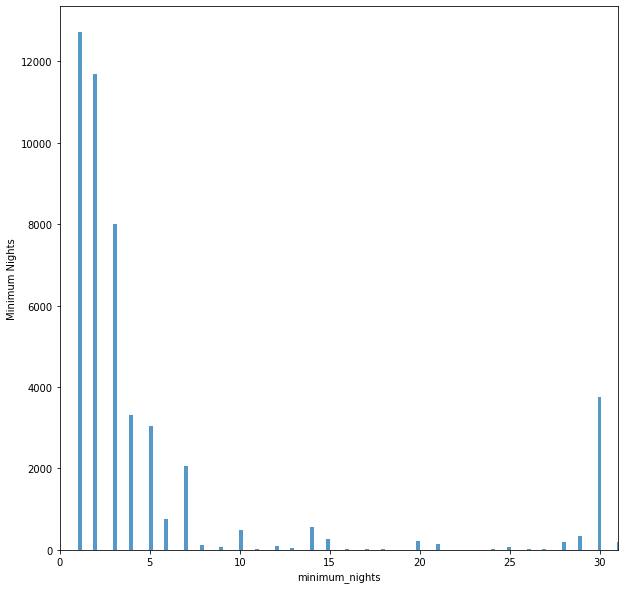

In [40]:
# Minimum Nights up to a month (30 days)
plt.figure(figsize=(10,10))
sns.histplot(df1['minimum_nights'].compute())
plt.xlim(0,31)
plt.ylabel("Minimum Nights")
plt.show()

We see that most observations are either for up to a week or for a month. We see very few outcomes for other values. One way we can feature engineer this is to look at days 1-7 and 30 separately. Later we will see if there are significant differences in prices given different groupings. 

**Number of Reviews:**

In [41]:
df1['number_of_reviews'].describe().compute()

count    48884.000000
mean        23.271991
std         44.551331
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: number_of_reviews, dtype: float64

In [42]:
df1['number_of_reviews'].value_counts().compute()

0      10051
1       5243
2       3464
3       2519
4       1994
       ...  
351        1
341        1
340        1
339        1
629        1
Name: number_of_reviews, Length: 394, dtype: int64

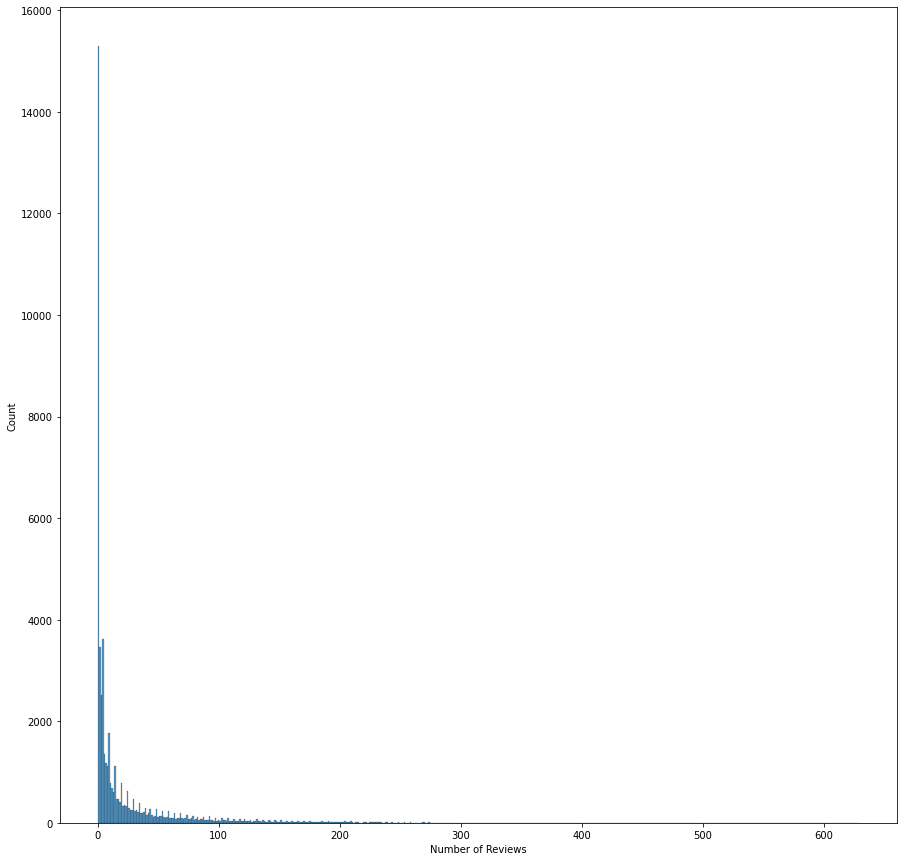

In [43]:
plt.figure(figsize=(15,15))
sns.histplot(df1['number_of_reviews'].compute())
plt.xlabel("Number of Reviews")
plt.show()

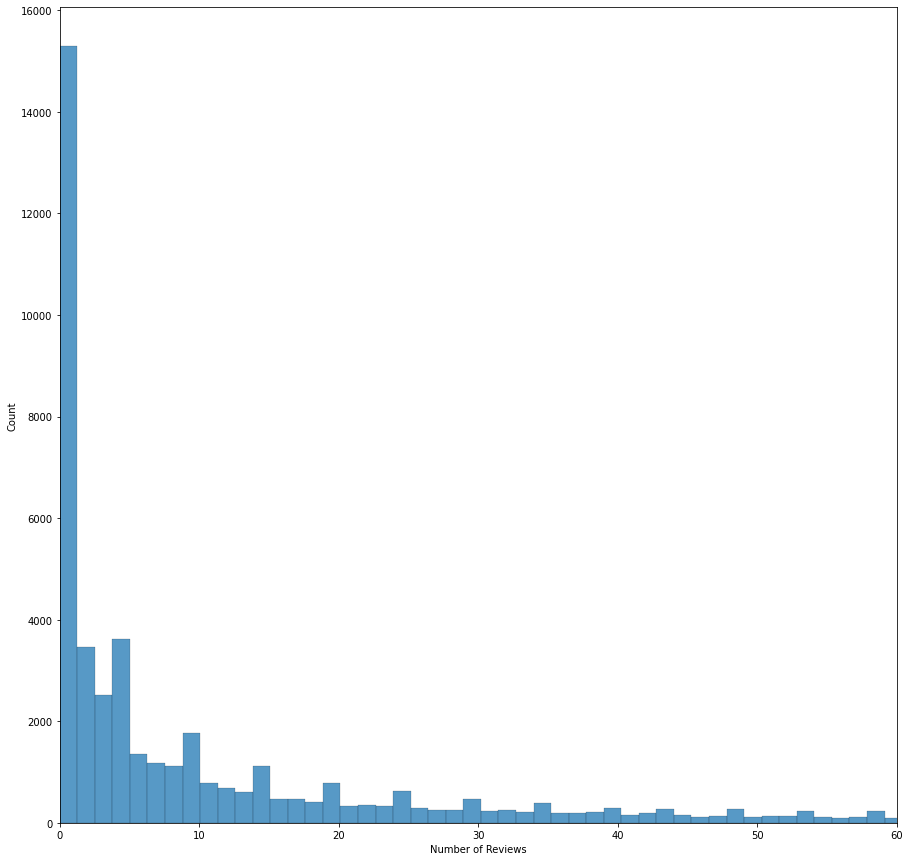

In [44]:
# Zooming in to ignore outliers and get better look
plt.figure(figsize=(15,15))
sns.histplot(df1['number_of_reviews'].compute())
plt.xlim(0,60)
plt.xlabel("Number of Reviews")
plt.show()


It seems that less reviews are more common than many reviews. The data is also skewed to the left. We may be able to treat this variable as a continuous variable. 

**Calculated Host Listings Count:**

In [45]:
df1['calculated_host_listings_count'].describe().compute()

count    48884.000000
mean         7.144628
std         32.956185
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

In [46]:
df1['calculated_host_listings_count'].value_counts().compute()

1      32301
2       6657
3       2853
4       1438
5        844
6        565
8        416
7        399
327      327
9        234
232      232
10       210
96       192
12       180
13       130
121      121
11       110
52       104
103      103
33        99
49        98
91        91
87        87
15        75
14        70
23        69
34        68
17        68
65        65
31        62
28        56
18        54
50        50
25        50
47        47
43        43
20        40
39        39
37        37
32        32
30        30
29        29
27        27
26        26
21        21
19        19
16        16
Name: calculated_host_listings_count, dtype: int64

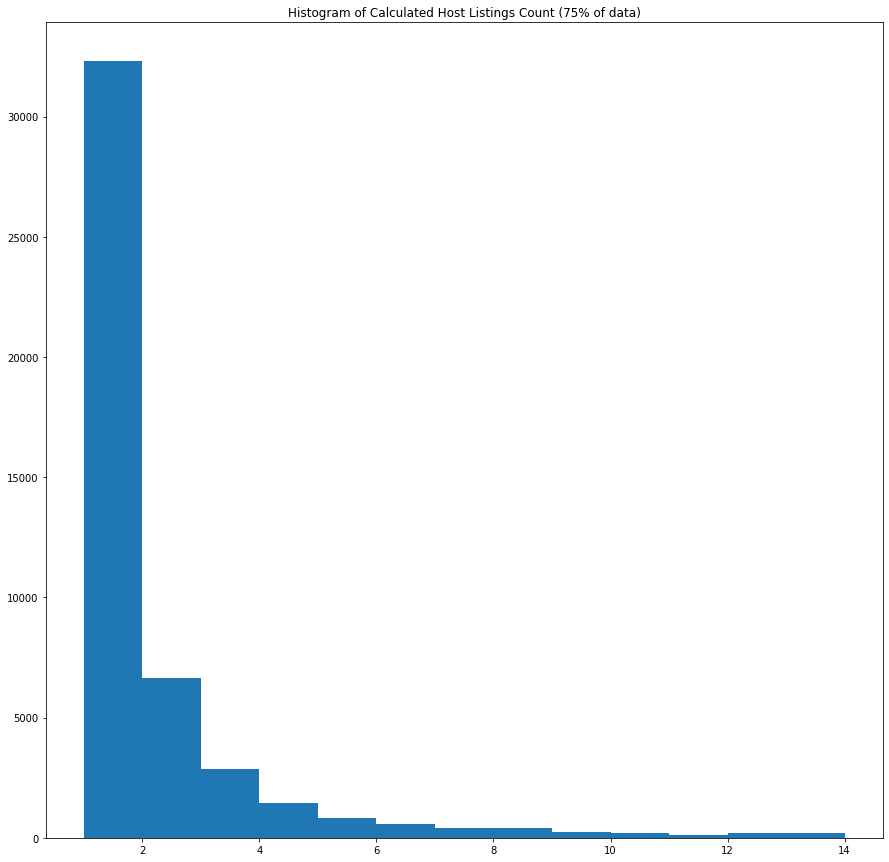

In [ ]:
plt.figure(figsize=(15,15))
plt.hist(df1['calculated_host_listings_count'].compute(), bins=range(min(df1['calculated_host_listings_count'].compute()), 15, 1))
plt.title("Histogram of Calculated Host Listings Count (75% of data)")
plt.show()

Similar to our previous variable, this variable has a left skew since less reviews are most common. In fact, most places have at most 2 reviews. We can likely treat this variable as categorical and will see if there is a way to group this varaible so that there is significant variation in price. We will make a copy of our current data frame in preparation for modeling without outier

**Availibility 365**

In [48]:
df1['availability_365'].value_counts().compute()

0      17530
365     1295
364      491
1        408
89       361
       ...  
195       26
183       24
196       24
181       23
202       20
Name: availability_365, Length: 366, dtype: int64

There is an availibility of 0 days for 17533 listings. We will consider dropping this variable

There is an availibility of 0 days for 17533 listings We may want to consider dropping this variable from the model. Let's see if we can find evidence of meaningful ways to group this variable to include in the analysis. We will want to find a grouping where there is significant variation in price. If places with higher availibility also have higher prices, then maybe we can leave the variable in the model and find a grouping that works. 

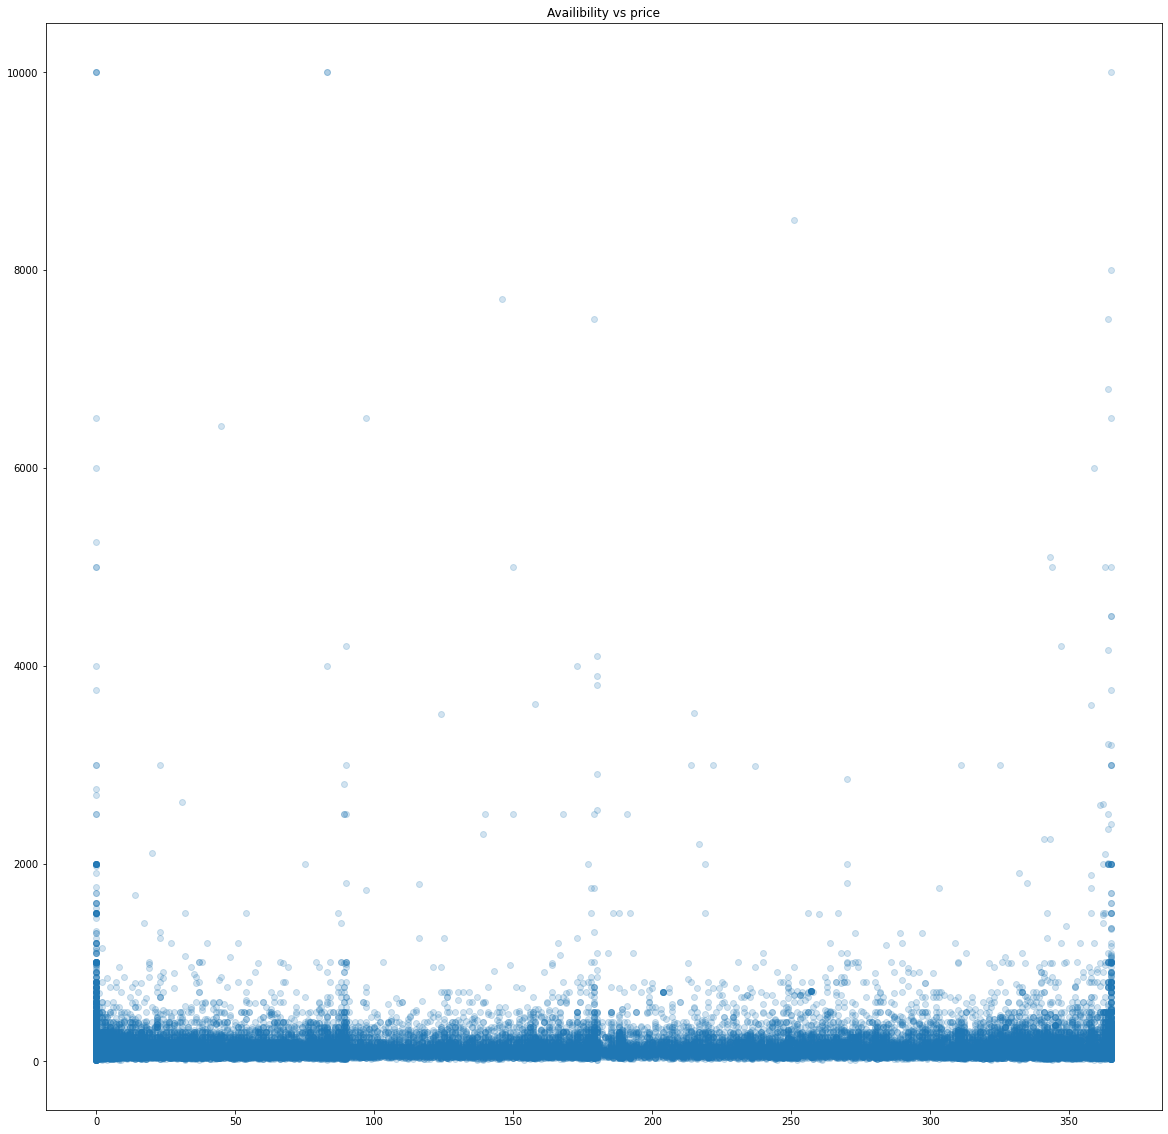

In [49]:
#Plotly lets us zoom
plt.figure(figsize=(20,20))

plt.scatter(df1["availability_365"].compute(), df1["price"].compute(), alpha=0.2)
#Zooming in to ignore outliers in plot
#plt.xlim(-1,10)
#plt.ylim(-1,500)
plt.title("Availibility vs price")
plt.show()

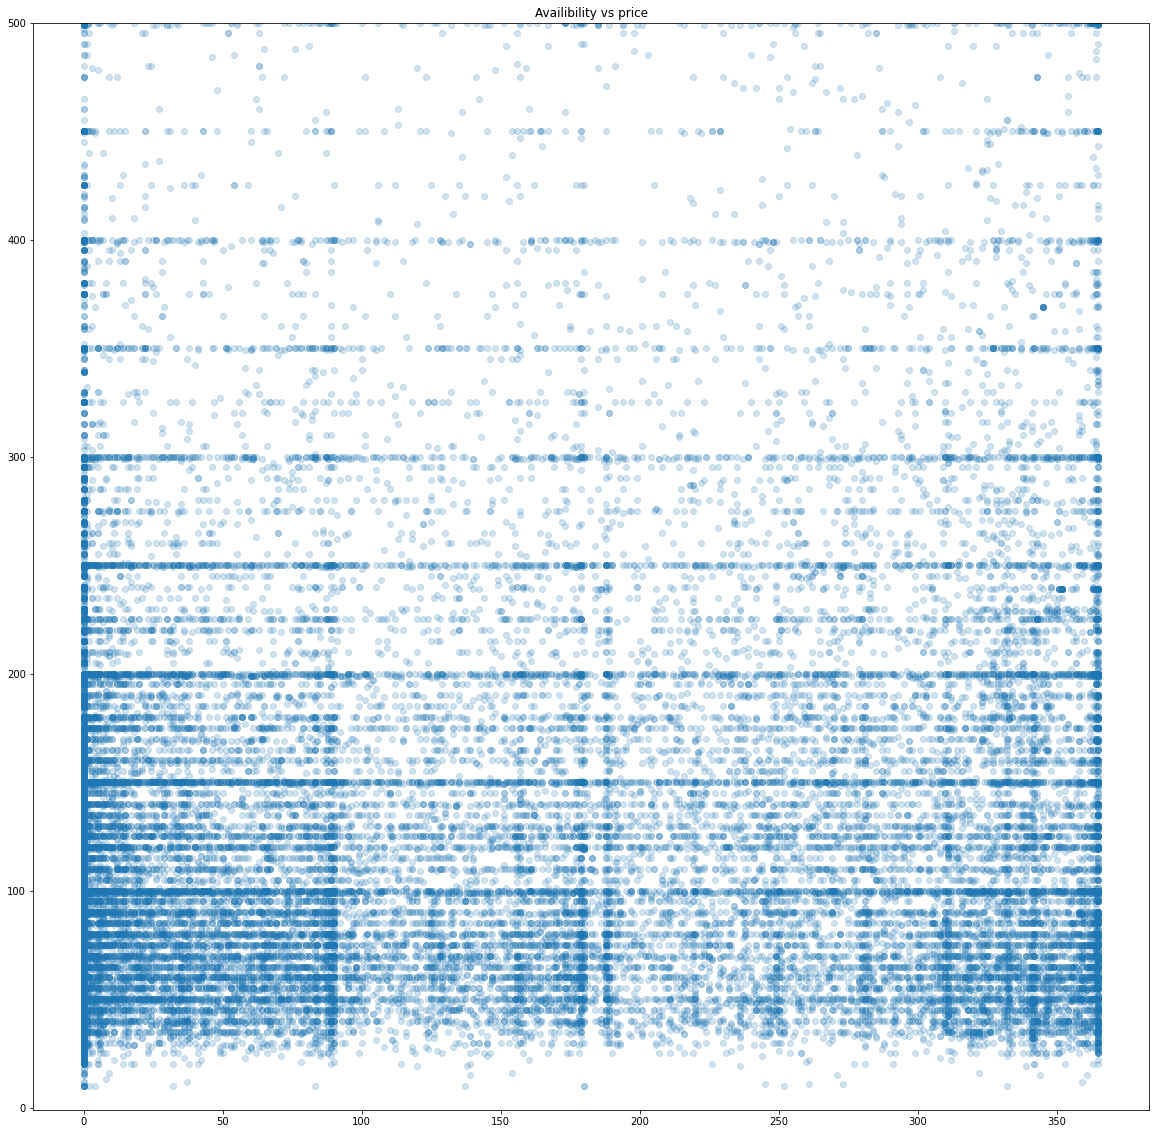

In [50]:
#Plotly lets us zoom
plt.figure(figsize=(20,20))

plt.scatter(df1["availability_365"].compute(), df1["price"].compute(), alpha=0.2)
#Zooming in to ignore outliers in plot
#plt.xlim(-1,10)
plt.ylim(-1,500)
plt.title("Availibility vs price")
plt.show()

I will be dropping availability from the model. We have no evidence of a grouping that can exist based on price. This just means that availibility is likely not a very good feature for explaining price. 

In [51]:
# Dropping
df1 = df1.drop(['availability_365'], axis=1)
df1.head()

neighbourhood_group  ... calculated_host_listings_count
0            Brooklyn  ...                              6
1           Manhattan  ...                              2
2           Manhattan  ...                              1
3            Brooklyn  ...                              1
4           Manhattan  ...                              1

[5 rows x 7 columns]

**Categorical Variables Univariate Analysis:**

These are the variables that I suspect will matter most in the analysis. In this section we will want to understand the frequency of each observation. In the next section we will see if there are significant differences in average price for the different categories. 

**Neighbourhood Group (New York City Borough):**

I believe that since some neighborhoods are more expensive than others. We will see significant variation in prices. First, let's see how common each Neighborhood group is in the data

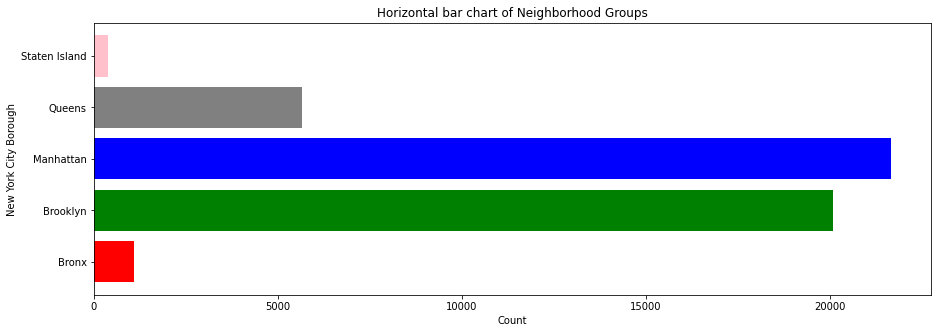

In [53]:
# Bar chart of grades
plt.figure(figsize=(15,5))
plt.barh(df1.groupby("neighbourhood_group")["neighbourhood_group"].count().compute().index, 
        df1.groupby("neighbourhood_group")["neighbourhood_group"].count().compute(), 
        color=["red","green","blue","grey","pink"])
plt.title("Horizontal bar chart of Neighborhood Groups")
plt.xlabel("Count")
plt.ylabel("New York City Borough")

plt.show()

In [54]:
df1['neighbourhood_group'].value_counts().compute()

Manhattan        21660
Brooklyn         20095
Queens            5666
Bronx             1090
Staten Island      373
Name: neighbourhood_group, dtype: int64

Manhattan and Brooklyn are the most common groups in the data. Making up about 85% of all the listings. 

**Neighborhood:**

If we include this variable we will want to group it in a way that show variation in prices. We will also want to understand what neighborhoods are in what neighborhood group. One way to treat this variable is to group by its distribution. We can group these neighborhoods into groups based on average price. For example, we can take the X% most expensive neighborhoods and the X% cheapest neighborhoods. If we include the neighborhood controls then we can reduce the need of explicitly controlling for the average priced neighborhoods. In other words, We want our models to account for the neighborhood group and then adjust the price depending if the listing is in a cheap or expensive neighborhood within the neighborhood group. 

In [55]:
df1['neighbourhood'].value_counts().compute()

Williamsburg          3919
Bedford-Stuyvesant    3710
Harlem                2658
Bushwick              2462
Upper West Side       1971
                      ... 
New Dorp                 1
Willowbrook              1
Fort Wadsworth           1
Richmondtown             1
Rossville                1
Name: neighbourhood, Length: 221, dtype: int64

In [56]:
# Let's ignore neighbourhoods with few observations (>20)
df1['neighbourhood'].value_counts().loc[lambda x : x>20].compute()

Williamsburg          3919
Bedford-Stuyvesant    3710
Harlem                2658
Bushwick              2462
Upper West Side       1971
                      ... 
Belmont                 24
Throgs Neck             24
University Heights      21
Clason Point            21
Arrochar                21
Name: neighbourhood, Length: 128, dtype: int64

In [57]:
df1['neighbourhood'].value_counts().loc[lambda x : x<=20].compute()

Howard Beach       20
Mount Hope         20
College Point      19
Jamaica Estates    19
Bronxdale          19
                   ..
New Dorp            1
Willowbrook         1
Fort Wadsworth      1
Richmondtown        1
Rossville           1
Name: neighbourhood, Length: 93, dtype: int64

Some neighborhoods have very few listings. Including all neighborhoods we have 221 unique neighborhoods. However, by excluding neighborhoods with 20 or less observation, we are left with 128 neighborhoods. 

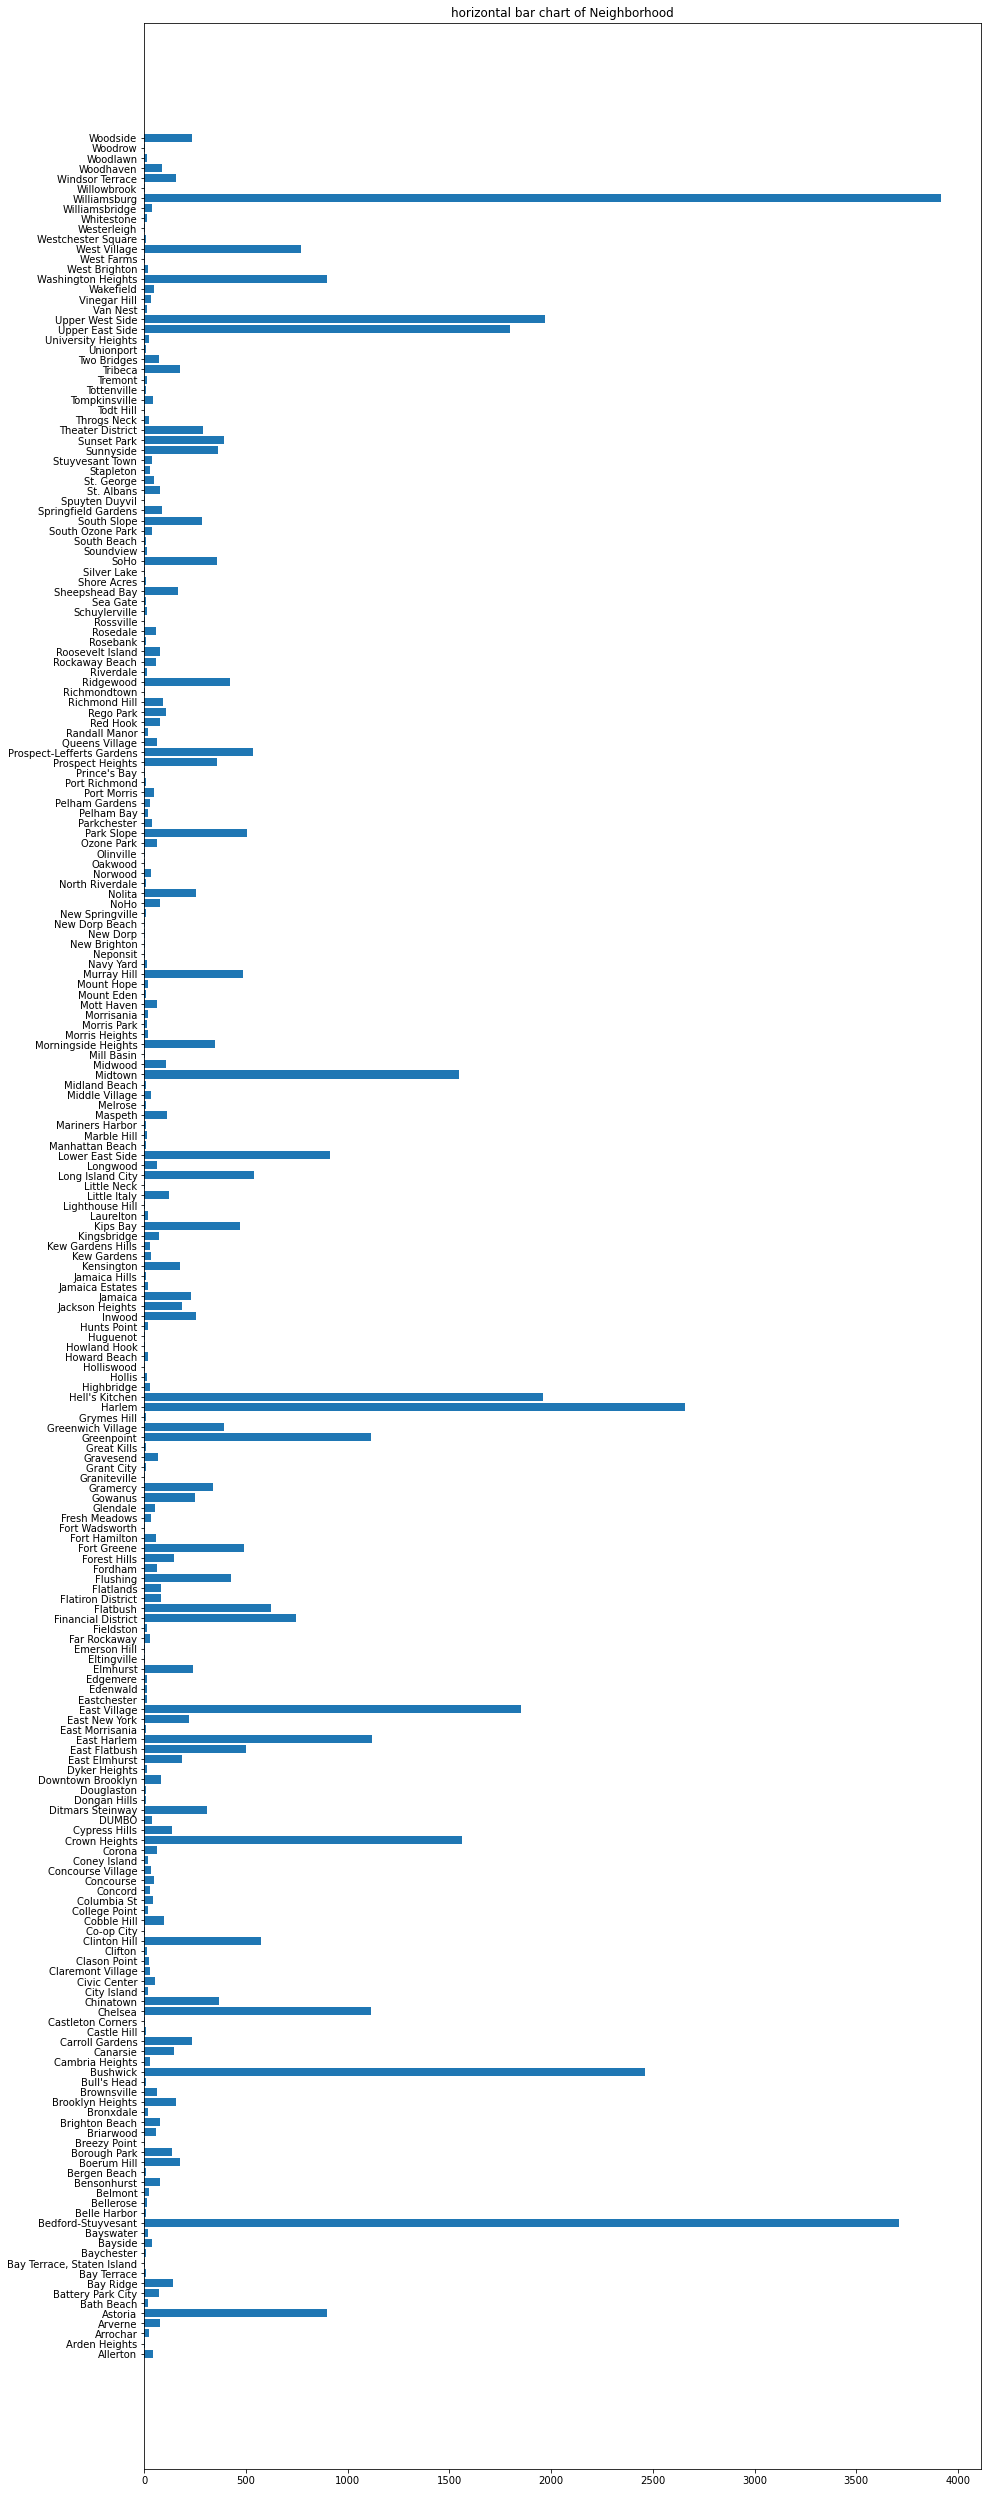

In [58]:
# Bar chart of grades
# sns.countplot lets me use hue
plt.figure(figsize=(15,45))
plt.barh(df1.groupby("neighbourhood")["neighbourhood"].count().compute().index, 
        df1.groupby("neighbourhood")["neighbourhood"].count().compute())
plt.title("horizontal bar chart of Neighborhood")
plt.show()

**What neighborhoods belong to what neighborhood groups?**

In [59]:
df1.groupby('neighbourhood_group')['neighbourhood'].value_counts().compute()

neighbourhood_group  neighbourhood
Bronx                Kingsbridge      70
                     Fordham          63
                     Longwood         62
                     Mott Haven       60
                     Concourse        50
                                      ..
Staten Island        New Dorp          1
                     Richmondtown      1
                     Rossville         1
                     Willowbrook       1
                     Woodrow           1
Name: neighbourhood, Length: 221, dtype: int64

In [60]:
df1.groupby('neighbourhood_group')['neighbourhood'].value_counts().loc[lambda x : x<=10].compute()

neighbourhood_group  neighbourhood             
Bronx                Melrose                       10
                     North Riverdale               10
                     Westchester Square            10
                     Castle Hill                    9
                     East Morrisania                9
                     Baychester                     7
                     Unionport                      7
                     Mount Eden                     6
                     Olinville                      4
                     Spuyten Duyvil                 4
                     Co-op City                     2
                     West Farms                     2
Brooklyn             Bergen Beach                  10
                     Manhattan Beach                8
                     Sea Gate                       7
                     Mill Basin                     4
Queens               Belle Harbor                   8
                     Douglaston   

In [61]:
df1.groupby('neighbourhood_group')['neighbourhood'].value_counts().loc[lambda x : 10 < x].compute()

neighbourhood_group  neighbourhood
Bronx                Kingsbridge      70
                     Fordham          63
                     Longwood         62
                     Mott Haven       60
                     Concourse        50
                                      ..
Staten Island        Concord          26
                     Arrochar         21
                     Randall Manor    19
                     West Brighton    18
                     Clifton          15
Name: neighbourhood, Length: 162, dtype: int64

**Room Type:**

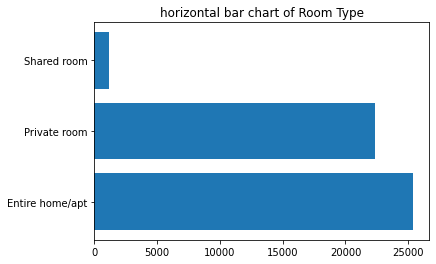

In [63]:
# Bar chart of grades
# sns.countplot lets me use hue
plt.barh(df1.groupby("room_type")["room_type"].count().index.compute(), 
        df1.groupby("room_type")["room_type"].count().compute())
plt.title("horizontal bar chart of Room Type")

plt.show()

In [64]:
df1.groupby('room_type')['room_type'].value_counts().compute()

room_type        room_type      
Entire home/apt  Entire home/apt    25407
Private room     Private room       22319
Shared room      Shared room         1158
Name: room_type, dtype: int64

**Bivariate Analysis and Feature Engineering:**

In this section we will look for relationships between our variables in price. We will be converting our numeric variables to categorical variables and look to see if there is variation in price. But first, we will see if there is a relationship between price and the numeric variable before converting. If there is not, we will convert those numeric fields to categories and see if there are significant differences in average price among different groupings.

**Minimum Nights:**




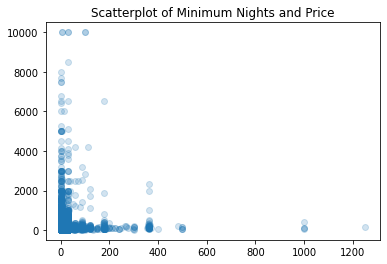

In [65]:
#Try a box plot rounded (find binning strategy)
plt.scatter(df1['minimum_nights'].compute(), df1['price'].compute(), alpha=0.2)
plt.title("Scatterplot of Minimum Nights and Price")
#plt.xlim(-1,200)
plt.show()

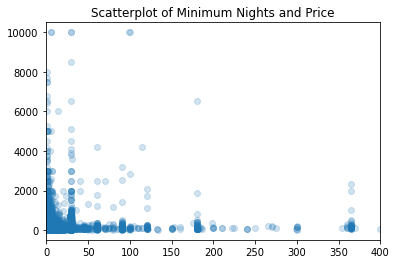

In [66]:
plt.scatter(df1['minimum_nights'].compute(), df1['price'].compute(), alpha=0.2)
plt.title("Scatterplot of Minimum Nights and Price")
plt.xlim(-1,400)
plt.show()

We do not see a clear relationship between number of nights and price. Earlier we saw that most listings were for up to a week long, or a month long. Observations at other values were less. Let's look at this scatter plot closer for those values

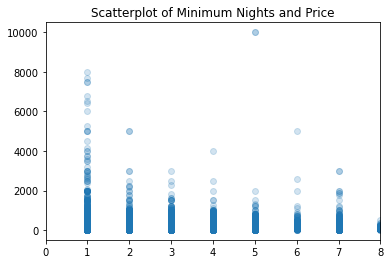

In [67]:
plt.scatter(df1['minimum_nights'].compute(), df1['price'].compute(), alpha=0.2)
plt.xlim(0,8)
plt.title("Scatterplot of Minimum Nights and Price")
plt.show()

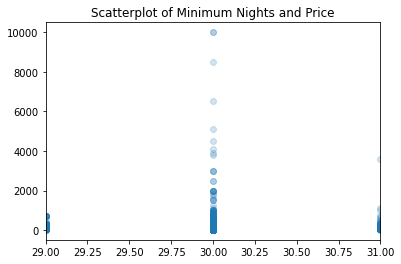

In [68]:
plt.scatter(df1['minimum_nights'].compute(), df1['price'].compute(), alpha=0.2)
plt.xlim(29,31)
plt.title("Scatterplot of Minimum Nights and Price")
plt.show()

Although it is hard to tell from this graph alone. There is reason to believe that maybe for days 2-7 there is not a lot of variaiton in price. However, the average price for listings of 1 day vs 2-7days vs 30 days is likely different. We will first separate this variable into 9 groups, one for each day (1-7), 30 days, and other. When we remove outliers, we may only try to predict prices for the subgroups where we have data. For now, we want to retain all data. 

**Converting Minimum Nights to a categorical variable:**

In [70]:
# 
def minimum_nights_groups(minimum_nights):
# if minimum_nights not in [1,2,...] return "other"
# else return minimum_nights
  if minimum_nights == 1:
    return '1-night'
  elif minimum_nights == 2:
    return '2-nights'
  elif minimum_nights == 3:
    return '3-nights'
  elif minimum_nights == 4:
    return '4-nights'
  elif minimum_nights == 5:
    return '5-nights'
  elif minimum_nights == 6:
    return '6-nights'
  elif minimum_nights == 7:
    return '7-nights'
  elif minimum_nights in [8,9,10,11,12,13,14,15,16,17,18,
                          19,20,21,22,23,24,25,26,27,28,29]:
    return '8-29 nights'
  elif minimum_nights == 30:
    return '30-nights'
  else:
    return "30+ nights"

# Converting the minimum nights column to categorical
df1['minimum_nights_grouped'] = df1['minimum_nights'].apply(minimum_nights_groups)

# How many are in each group?
print(df1.groupby("minimum_nights_grouped")["minimum_nights"].count().compute())



minimum_nights_grouped
1-night        12717
2-nights       11693
3-nights        7998
30+ nights       747
30-nights       3758
4-nights        3302
5-nights        3033
6-nights         752
7-nights        2058
8-29 nights     2826
Name: minimum_nights, dtype: int64


In [71]:
df1.head()

neighbourhood_group  ... minimum_nights_grouped
0            Brooklyn  ...                1-night
1           Manhattan  ...                1-night
2           Manhattan  ...               3-nights
3            Brooklyn  ...                1-night
4           Manhattan  ...            8-29 nights

[5 rows x 8 columns]

Now we want to find a way to group the data so that we can find variation in price. First thing we will do is to visualize the data and see if the different groups vary with price. 



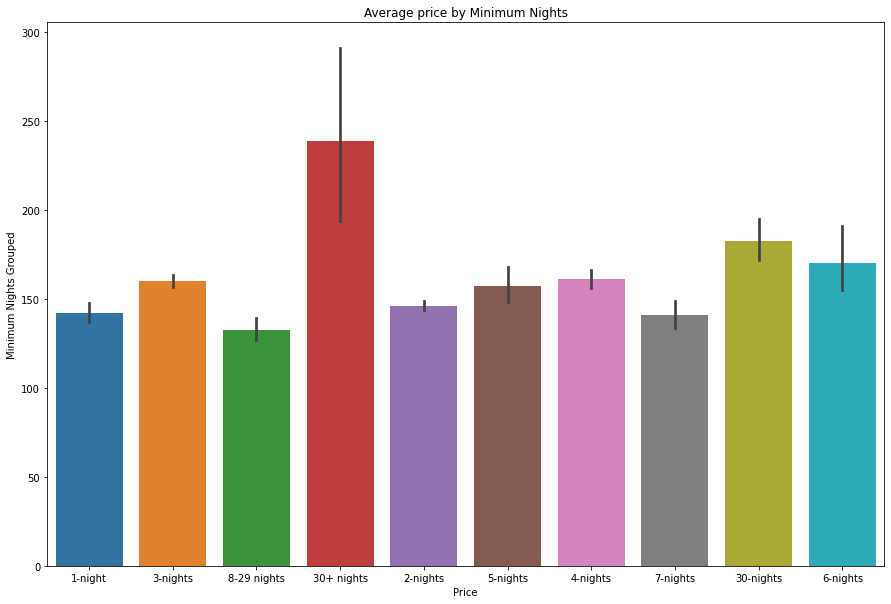

In [72]:
plt.figure(figsize=(15,10))
sns.barplot(df1['minimum_nights_grouped'].compute(), df1['price'].compute())
plt.title("Average price by Minimum Nights")
plt.xlabel("Price")
plt.ylabel("Minimum Nights Grouped")
plt.show()

While we have not explicitly shown that average price is statistically different among groups, the bar plots do reveal than on average, prices seem to be highest for rooms where the minimum nights is a month long. Here, the average price is greater than for any other grouping. Looking at the individual day data. The average prices do not seem to vary by too much. We also see that the average price of the other category, is somewhere between the average price of the individual days. We see that the average price is highest for the 30 day minimum listings. Considering that most minimum nights fall at around 1 and 2 days and both have low averages. We may be seeing more variations in other days due to outliers in the data. There are different ways we can group the data, if we find no problems with overfitting, we can include everyday as a categorical variable. First, we will test what groups have significant differences in prices. 

In [74]:
# Anova Tukey try
import scipy.stats as stats
# Test whether group differences are significant
minimum_nights = df1['minimum_nights_grouped'].unique().compute()
grouped_df = df1.groupby("minimum_nights_grouped")
for var in ["price"]:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(minimum_nights)):
        for j in range(i+1, len(minimum_nights)):
            print("t-test between groups {0} and {1}:".format(minimum_nights[i], minimum_nights[j]))
            print(stats.ttest_ind(
                df1[df1["minimum_nights_grouped"]==minimum_nights[i]][var], 
                df1[df1["minimum_nights_grouped"]==minimum_nights[j]][var]
            ))

------------------------------------------------
Comparisons for variable: price
------------------------------------------------
t-test between groups 1-night and 3-nights:
Ttest_indResult(statistic=-5.36541340838815, pvalue=8.163106211089266e-08)
t-test between groups 1-night and 8-29 nights:
Ttest_indResult(statistic=1.7134397126241547, pvalue=0.08665161871109403)
t-test between groups 1-night and 30+ nights:
Ttest_indResult(statistic=-8.108991051247095, pvalue=5.542889144682729e-16)
t-test between groups 1-night and 2-nights:
Ttest_indResult(statistic=-1.461832314021033, pvalue=0.14380004076938444)
t-test between groups 1-night and 5-nights:
Ttest_indResult(statistic=-2.6908859426982774, pvalue=0.007133776662138114)
t-test between groups 1-night and 4-nights:
Ttest_indResult(statistic=-3.778248042953029, pvalue=0.0001585074029023277)
t-test between groups 1-night and 7-nights:
Ttest_indResult(statistic=0.13548095047683617, pvalue=0.8922334705665663)
t-test between groups 1-night an

As we expect, some differences between groups are statistically significant while others are not. Rather than grouping a different way now, I will study the remaining variables. It may be the case that there are significant differences among different groups given we are in a certain neighborhood. For now, we will proceed with the following grouping.

**Number of Reviews:**

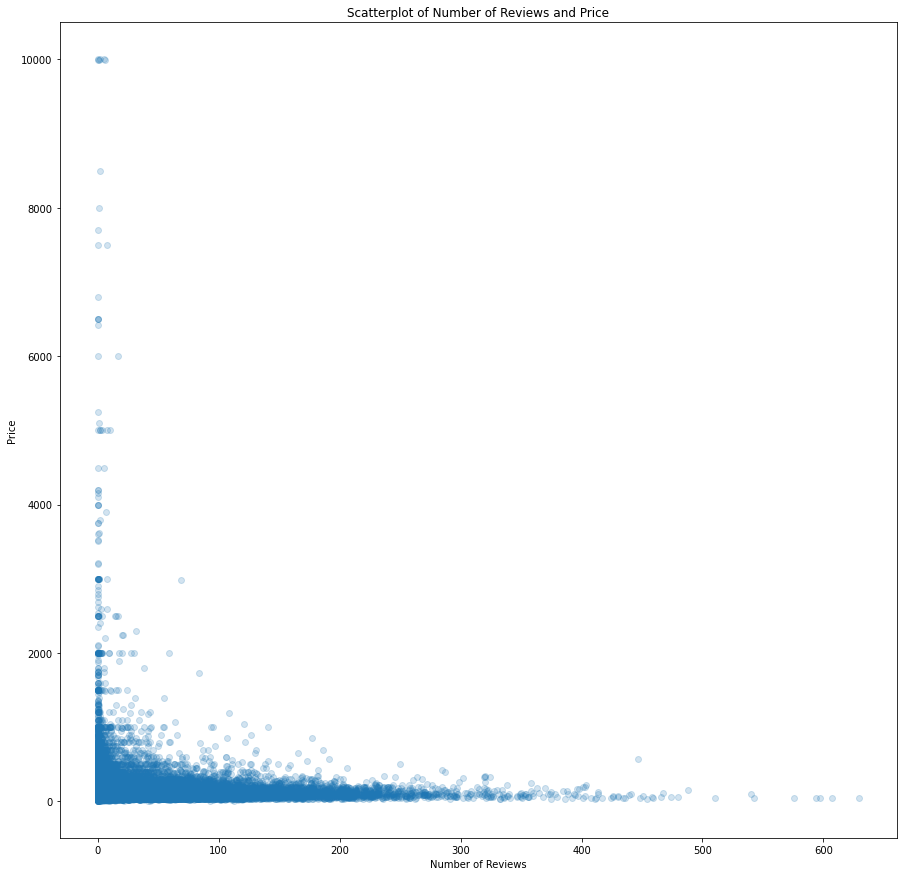

In [75]:
plt.figure(figsize=(15,15))
plt.scatter(df1['number_of_reviews'].compute(), df1['price'].compute(), alpha=0.2)
plt.title("Scatterplot of Number of Reviews and Price")
#Limiting x-axis
#plt.xlim(-1,200)
plt.xlabel("Number of Reviews")
plt.ylabel("Price")
plt.show()

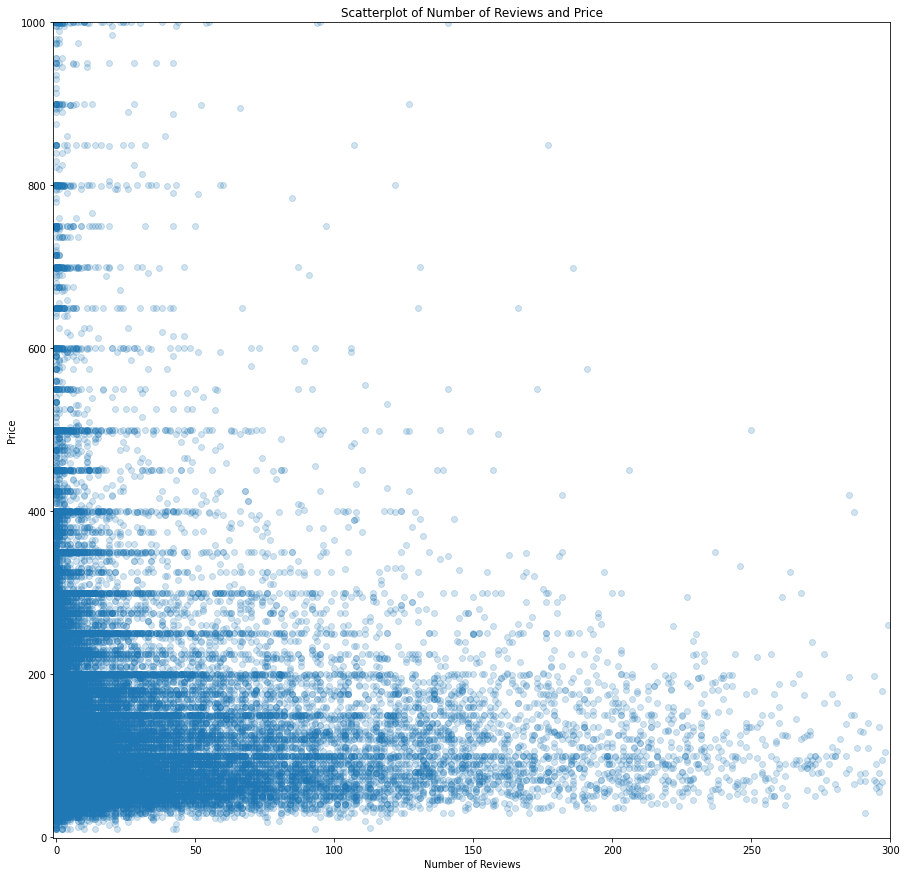

In [76]:
plt.figure(figsize=(15,15))
plt.scatter(df1['number_of_reviews'].compute(), df1['price'].compute(), alpha=0.2)
plt.title("Scatterplot of Number of Reviews and Price")
plt.xlim(-1,300)
plt.ylim(-1,1000)
plt.xlabel("Number of Reviews")
plt.ylabel("Price")
plt.show()

As a continuous variable, there does not seem to be a lot of variation in price. This is because we have a lot more data, and therefore variation, in prices at lower values of number of reviews. For this linear regression, I will see if there is a way to group the data to see if we can find ways to explain price. A linear regression will try to fit a line. No matter what line it fits, it will likely estimate more extreme values of price for listings with high number of reviews. We will be looking a Linear, Log-Linear, and Log-Log regression models. Log transforming this variable will reduce the skew and tendency to over or underestimate price

In [77]:
df1['number_of_reviews'].value_counts().loc[lambda x : x>=600].compute()

0     10051
1      5243
2      3464
3      2519
4      1994
5      1617
6      1357
7      1179
8      1127
9       964
10      803
11      778
12      681
13      611
Name: number_of_reviews, dtype: int64

There are less and less number of listings with high number of reviews. Its possible that, As listings are reviewed more, they are likely more popular or in higher demand. This can likely mean that the price is lower for those listings with more reviews. I just believe more affordable places are likely to get more reviews. Another difference may just be the location itself. Maybe places that get reviewed more are places that are in high demand. Meaning higher prices. 

**Calculated Host Listings Count:**

In [78]:
df1['calculated_host_listings_count'].value_counts().compute()

1      32301
2       6657
3       2853
4       1438
5        844
6        565
8        416
7        399
327      327
9        234
232      232
10       210
96       192
12       180
13       130
121      121
11       110
52       104
103      103
33        99
49        98
91        91
87        87
15        75
14        70
23        69
34        68
17        68
65        65
31        62
28        56
18        54
50        50
25        50
47        47
43        43
20        40
39        39
37        37
32        32
30        30
29        29
27        27
26        26
21        21
19        19
16        16
Name: calculated_host_listings_count, dtype: int64

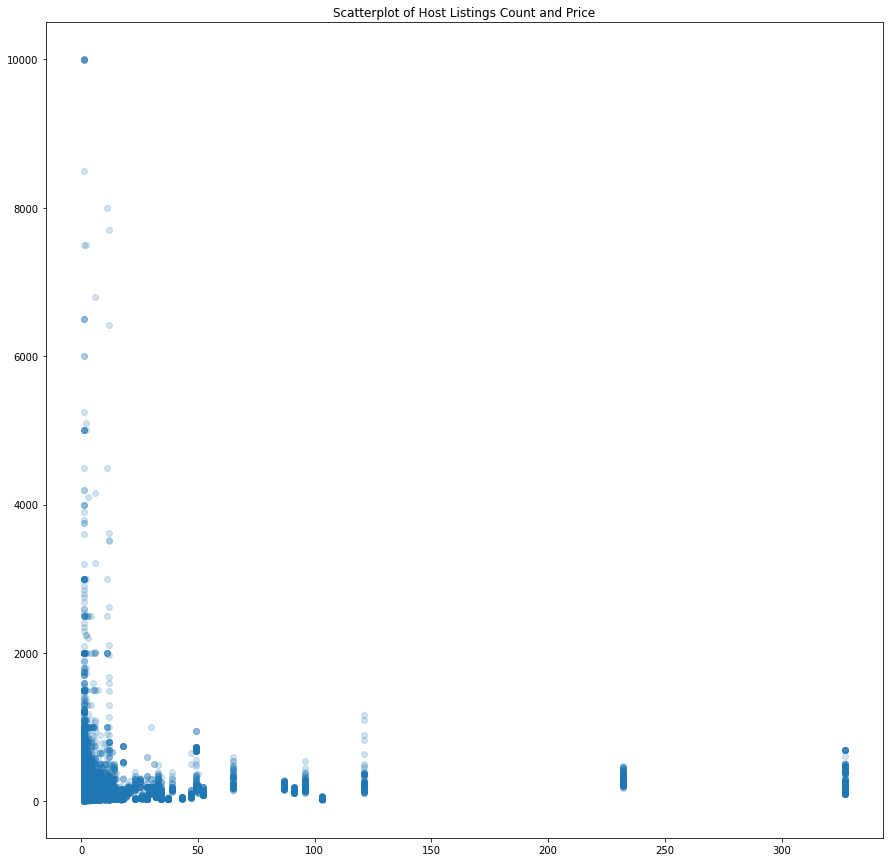

In [80]:
plt.figure(figsize=(15,15))
plt.scatter(df1['calculated_host_listings_count'].compute(), df1['price'].compute(), alpha=0.2)
plt.title("Scatterplot of Host Listings Count and Price")
plt.show()

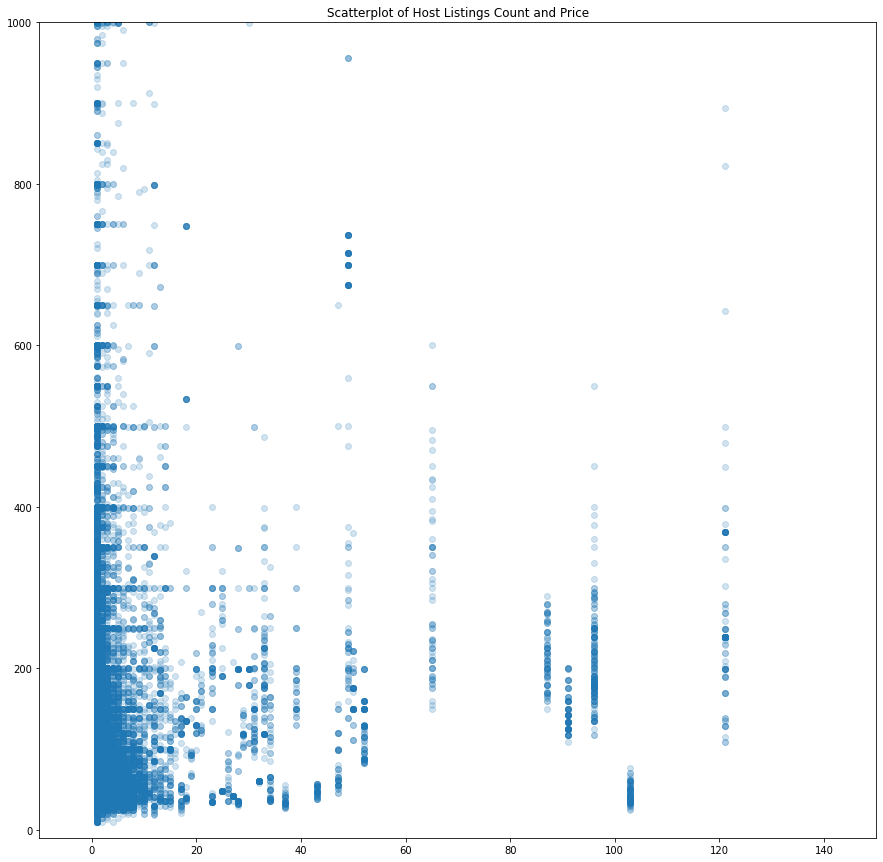

In [81]:
plt.figure(figsize=(15,15))
plt.scatter(df1['calculated_host_listings_count'].compute(), df1['price'].compute(), alpha=0.2)
plt.title("Scatterplot of Host Listings Count and Price")
#Limiting x and y axis to zoom in
plt.xlim(-10,150)
plt.ylim(-10, 1000)
plt.show()

It does not seem like the number of reviews can explain price. We see more variation in prices at lower levels because there are more listings. We will treat this variable as categorical to see if price is different in different ranges. Earlier bins will be smaller since they have more data.

In [82]:
def grouped_listing_count(calculated_host_listings_count):
# if minimum_nights not in [1,2,...] return "other"
# else return minimum_nights
  if calculated_host_listings_count == 1:
    return '1 listing'
  if calculated_host_listings_count == 2:
    return '2 listings' 
  if calculated_host_listings_count == 3:
    return '3 listings' 
  if calculated_host_listings_count == 4:
    return '4 listings' 
  if calculated_host_listings_count == 5:
    return '5 listings'
  elif calculated_host_listings_count in [6,7,8,9,10]:
    return '6-10'
  elif calculated_host_listings_count in [11,12,13,14,15]:
    return '11-15'
  elif calculated_host_listings_count in [16,17,18,19,20]:
    return '16-20'
  elif calculated_host_listings_count in [21,22,23,24,25]:
    return '21-25'
  else:
    return "26+ listings"

# Converting the minimum nights column to categorical
df1['grouped_listing_count'] = df1['calculated_host_listings_count'].apply(grouped_listing_count)

# How many are in each group?
print(df1.groupby("grouped_listing_count")["calculated_host_listings_count"].count().compute())

grouped_listing_count
1 listing       32301
11-15             565
16-20             197
2 listings       6657
21-25             140
26+ listings     2065
3 listings       2853
4 listings       1438
5 listings        844
6-10             1824
Name: calculated_host_listings_count, dtype: int64


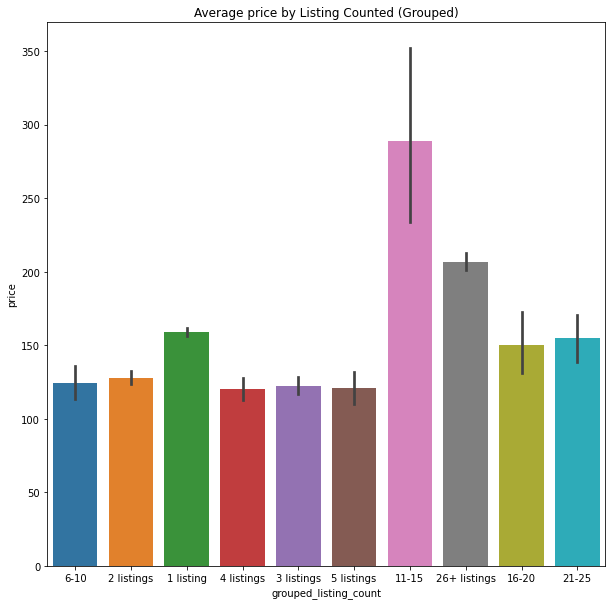

In [83]:
plt.figure(figsize=(10,10))
sns.barplot(df1['grouped_listing_count'].compute(), df1['price'].compute())
plt.title("Average price by Listing Counted (Grouped)")
plt.show()

By grouping the data we see that more listing counts does not neccesarily imply lower or higher prices. Another reason not to treat as a continous variable in our model

We will make a copy of the dataframe at this point since some variables will be feature engineered slightly different given the different subsets of the data

In [84]:
# For models without outliers in price
df2 = df1.copy()
df2 = df2[df2['price'] <= 300]
df2.head()

neighbourhood_group  ... grouped_listing_count
0            Brooklyn  ...                  6-10
1           Manhattan  ...            2 listings
2           Manhattan  ...             1 listing
3            Brooklyn  ...             1 listing
4           Manhattan  ...             1 listing

[5 rows x 9 columns]

**Neighborhood Group:**

As we might suspect, different Neighborhood Groups are more expensive than others


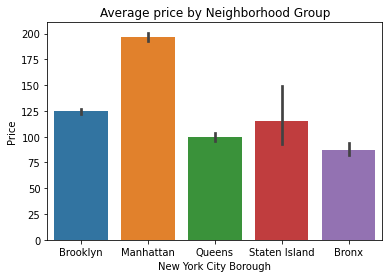

In [85]:
sns.barplot(df1['neighbourhood_group'].compute(), df1['price'].compute())
plt.title("Average price by Neighborhood Group")
plt.xlabel("New York City Borough")
plt.ylabel("Price")
plt.show()

In [86]:
# Anova Tukey
import scipy.stats as stats
# Test whether group differences are significant
minimum_nights = df1['neighbourhood_group'].unique().compute()
grouped_df = df1.groupby("neighbourhood_group")
for var in ["price"]:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(minimum_nights)):
        for j in range(i+1, len(minimum_nights)):
            print("t-test between groups {0} and {1}:".format(minimum_nights[i], minimum_nights[j]))
            print(stats.ttest_ind(
                df1[df1["neighbourhood_group"]==minimum_nights[i]][var], 
                df1[df1["neighbourhood_group"]==minimum_nights[j]][var]
            ))

------------------------------------------------
Comparisons for variable: price
------------------------------------------------
t-test between groups Brooklyn and Manhattan:
Ttest_indResult(statistic=-29.983706549875166, pvalue=1.909636438057947e-195)
t-test between groups Brooklyn and Queens:
Ttest_indResult(statistic=9.06707021384297, pvalue=1.307376185773838e-19)
t-test between groups Brooklyn and Staten Island:
Ttest_indResult(statistic=0.9750355510115101, pvalue=0.32955414983641085)
t-test between groups Brooklyn and Bronx:
Ttest_indResult(statistic=6.454680719365951, pvalue=1.1079656321394247e-10)
t-test between groups Manhattan and Queens:
Ttest_indResult(statistic=24.135540978727448, pvalue=2.2859626117810526e-127)
t-test between groups Manhattan and Staten Island:
Ttest_indResult(statistic=5.397758658646191, pvalue=6.817556365172427e-08)
t-test between groups Manhattan and Bronx:
Ttest_indResult(statistic=12.34314439223042, pvalue=6.86068800148683e-35)
t-test between groups 

**Neighborhood:**

In [97]:
df1.groupby('neighbourhood').agg({'price': 'mean'}).compute().sort_values('price').reset_index()

neighbourhood       price
0       Bull's Head   47.333333
1       Hunts Point   50.500000
2           Tremont   51.545455
3         Soundview   53.466667
4          New Dorp   57.000000
..              ...         ...
216       Riverdale  442.090909
217        Sea Gate  487.857143
218         Tribeca  490.638418
219         Woodrow  700.000000
220  Fort Wadsworth  800.000000

[221 rows x 2 columns]

In [100]:
sorted_df = df1.groupby('neighbourhood').agg({'price': 'mean'}).compute().sort_values('price').reset_index()
sorted_df
sorted_hoods = sorted_df['neighbourhood']
sorted_hoods

0         Bull's Head
1         Hunts Point
2             Tremont
3           Soundview
4            New Dorp
            ...      
216         Riverdale
217          Sea Gate
218           Tribeca
219           Woodrow
220    Fort Wadsworth
Name: neighbourhood, Length: 221, dtype: object

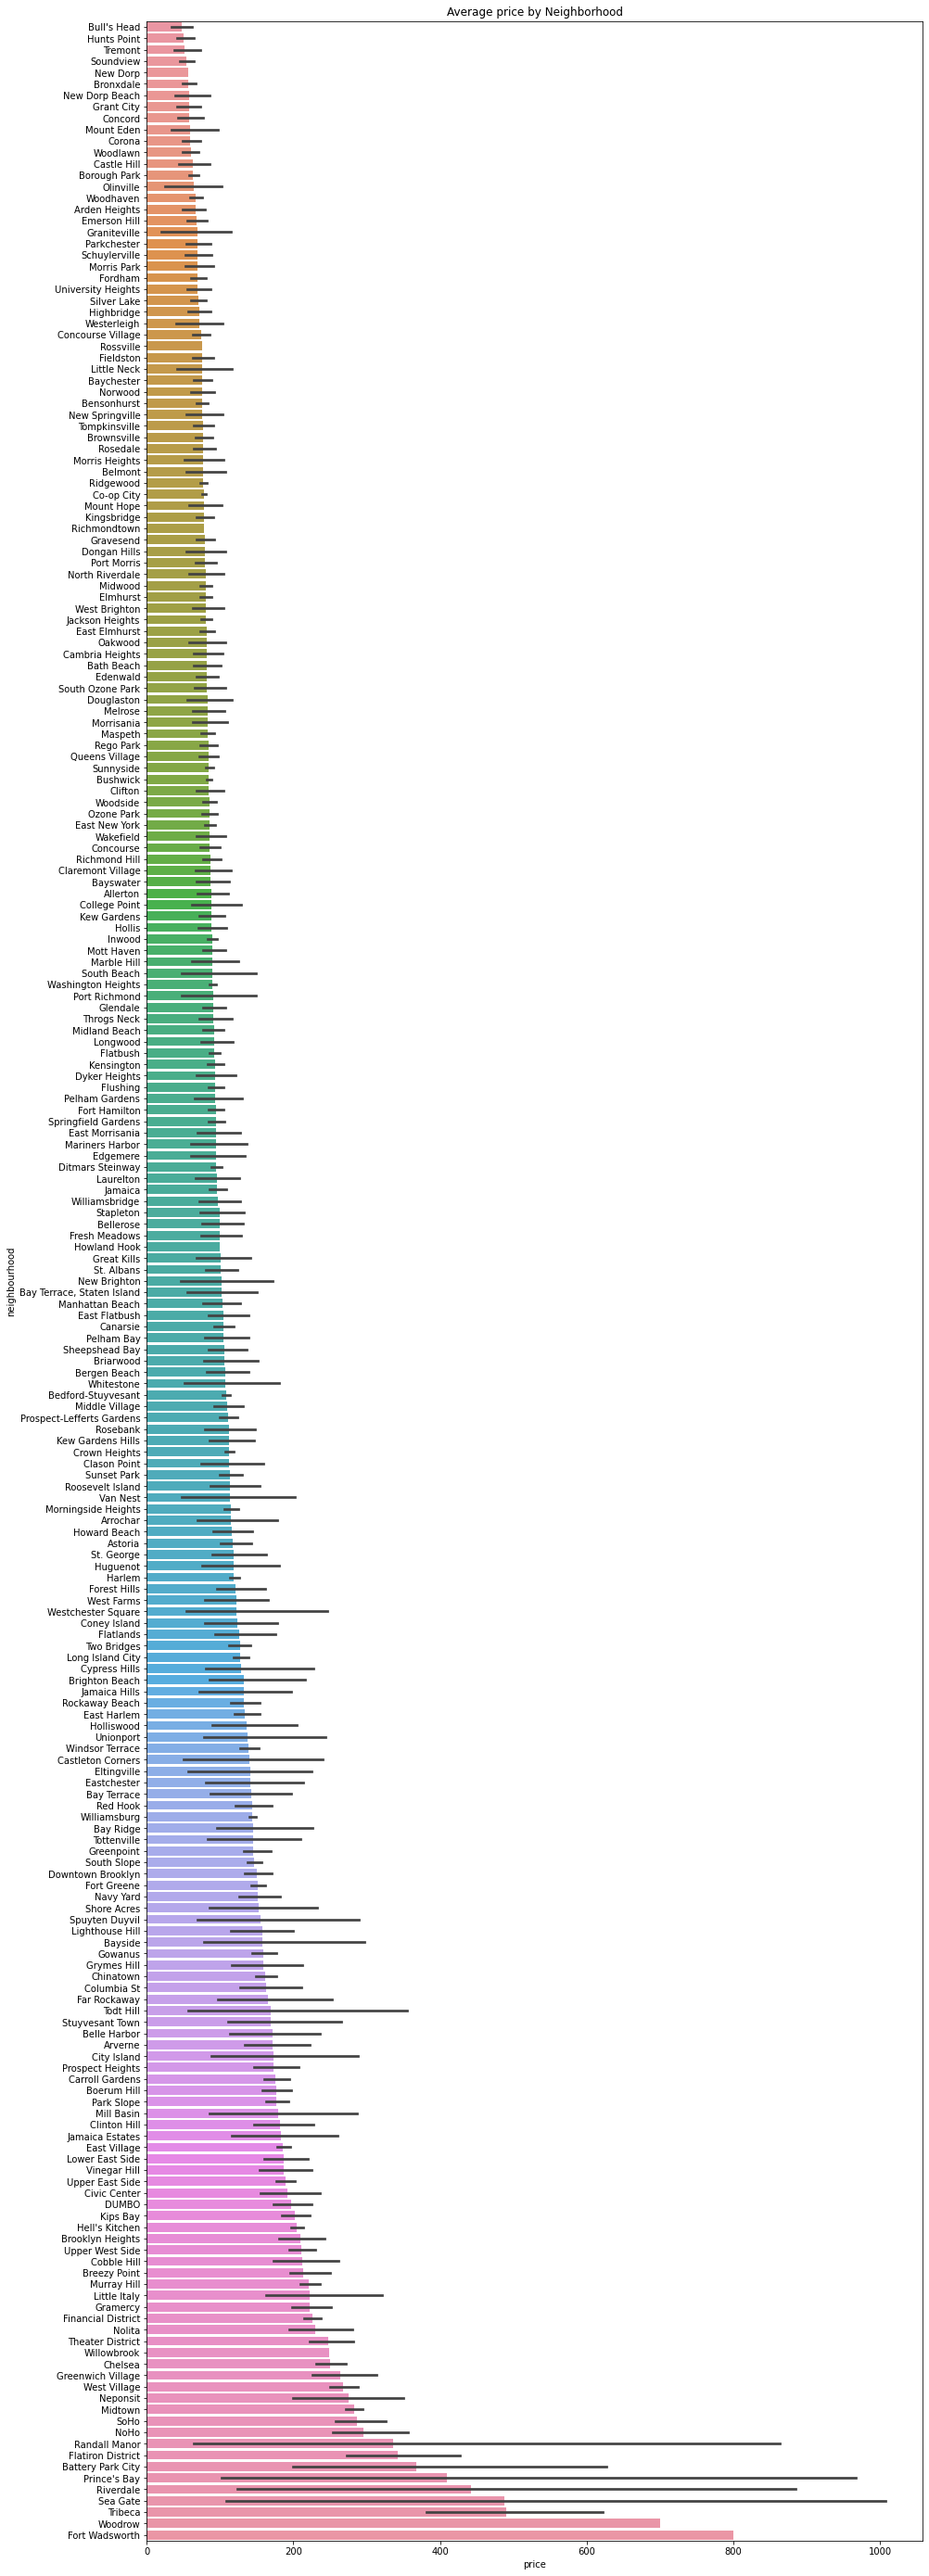

In [102]:
plt.figure(figsize=(15,50))
sns.barplot(y=df1['neighbourhood'].compute(), x=df1['price'].compute(), order=sorted_hoods, orient='h')
plt.title("Average price by Neighborhood")
plt.show()

Some neighborhoods are more expensive than others. We are likely not able to control for each individual neighbourhood. One meaningful way that we can group the data is to group the neighborhoods into groups based on their price. For example, The most expensive neighborhoods can be classified together. We also need to recall the neighborhoods with few observations, we would like to omit these neighborhoods from the expensive and cheap neighborhood groups.

Expensive:

Fort Wadsworth, Woodrow, Tribeca, Sea Gate, Riverdale, Prince's Bay, Baltic Park City, Flat Iron District, Randall Manor, NoHo, SoHo, Midtown, Neponsit, West Village

Cheapest:

Bulls Head, Hunt's Point, Tremont, Soundview, Mount Eden, Concord, Woodlawn, Graniteville, Borough Park, New Dorp, Bronxdale, New Dorp Beach, Grant City, Corona, Castle Hill, Olinville, Woodhaven, Arden Heights, Emerson Hill, Parkchester, Schuylerville, Morris Park, Fordham, University Heights, Silver Lake, Highbridge, Westerleigh, Concourse Village, Rossville, Fieldston, Little Neck, Norwood, Bensonhurst, New Springvale, Tompkinsville, Brownsville, Rosedale, Morris Heights, Belmont, Ridgewood, Co-op City, Mount Hope, Kingsbridge, Richmondtown, Gravesend, Dongan Hills, Port Morris, North Riverdale, Midwood, Elmhurst, West Brighton,  Jackson Heights, East Elmhurst,
Oakwood, Cambria Heights, Bath Beach, Edenwald, South Ozone Park, Douglaston, Melrose, Morrisania, Maspeth, Rego Park, Queens Village, Sunnyside

We have more cities grouped into our Cheapest listings. The reason for this is that these cities have fewer observations and even including for many, the variation in prices is small between the groups. (On average). I included a category for most expensive because these neighborhoods are a lot more expensive than others. If I group these variables with my other expensive, they are likely to bias the data. (I can regroup these later if I have problems with Overfitting)(

**What are the best ways to group? Is sorting possible?**
[How to use Discretization Transforms in Machine Learning](https://machinelearningmastery.com/discretization-transforms-for-machine-learning/)

In [103]:
def neighbourhood_price(neighbourhood):
  if neighbourhood in ['Fort Wadsworth', 'Woodrow', 'Tribeca', 'Sea Gate', 'Riverdale', "Prince's Bay", 'Battery Park City']:
    return 'most expensive'
  elif neighbourhood in ['Midtown', 'Neoponsit', 'West Village', 'SoHo', 'NoHo', 'Randall Manor', 'Flatiron District', 'Greenwich Village']:
    return 'expensive'
  elif neighbourhood in ["Bull's Head", "Hunts Point", 'Tremont', 'Soundview', 'New Dorp', 'Bronxdale', 'New Dorp Beach', 'Grant City', 'Mount Eden', 
                         'Concord', 'Woodlawn', 'Corona', 'Castle Hill', 'Borough Park', 'Olinville']:
    return 'cheapest'
  elif neighbourhood in ['Graniteville', 'Woodhaven', 'Arden Heights',
                         'Emerson Hill', 'Parkchester', 'Schuylerville', 'Morris Park', 'Fordham', 'University Heights', 'Silver Lake', 'Highbridge',
                         'Westerleigh', 'Concourse Village', 'Rossville', 'Fieldston', 'Little Neck', 'Norwood', 'Bensonhurst', 'New Springville',
                         'Tompkinsville', 'Brownsville', 'Rosedale', 'Morris Heights', 'Belmont', 'Ridgewood', 'Co-op City', 'Mount Hope', 'Kingsbridge',
                         'Richmondtown', 'Gravesend', 'Dongan Hills', 'Port Morris', 'North Riverdale', 'Midwood', 'Elmhurst', 'West Brighton', 'Jackson Heights',
                         'East Elmhurst', 'Oakwood', 'Cambria Heights', 'Bath Beach', 'Edenwald', 'South Ozone Park', 'Douglaston', 'Melrose', 'Morrisania',
                         'Maspeth', 'Rego Park', 'Queens Village', 'Sunnyside', 'Bushwick']:
    return 'cheap'
  else:
    return "moderate"

# Converting the minimum nights column to categorical
df1['neighbourhood_price'] = df1['neighbourhood'].apply(neighbourhood_price)

# How many are in each group?
print(df1.groupby("neighbourhood_price")["neighbourhood"].count().compute())

neighbourhood_price
cheap              5269
cheapest            337
expensive          3240
moderate          39767
most expensive      271
Name: neighbourhood, dtype: int64


**Room Type:**

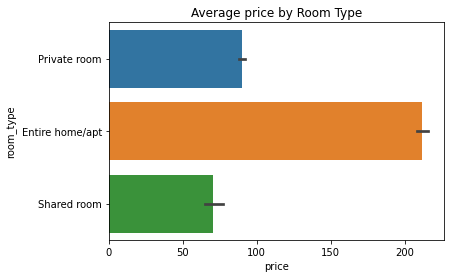

In [104]:
sns.barplot(y=df1['room_type'].compute(), x=df1['price'].compute())
plt.title("Average price by Room Type")
plt.show()

**EDA for data frame where (price <= $300)**

The only variable that will be grouped differently given the new subspace of price is Neighborhood group. This is because the average price per neighborhood changes when removing some listings. Outliers present before must have had a difference in price. 

In [105]:
df2.describe().compute()

price  ...  calculated_host_listings_count
count  45527.00000  ...                    45527.000000
mean     118.31265  ...                        6.294616
std       65.89067  ...                       29.725327
min       10.00000  ...                        1.000000
25%       65.00000  ...                        1.000000
50%      100.00000  ...                        1.000000
75%      155.00000  ...                        2.000000
max      300.00000  ...                      327.000000

[8 rows x 4 columns]

**Neighborhood:**

In [107]:
sorted_df2 = df2.groupby('neighbourhood').agg({'price': 'mean'}).compute().sort_values('price').reset_index()
sorted_df2
sorted_hoods2 = sorted_df2['neighbourhood']
sorted_hoods2

0       Bull's Head
1       Hunts Point
2           Tremont
3         Soundview
4            Corona
           ...     
214            NoHo
215         Tribeca
216    Breezy Point
217        Neponsit
218     Willowbrook
Name: neighbourhood, Length: 219, dtype: object

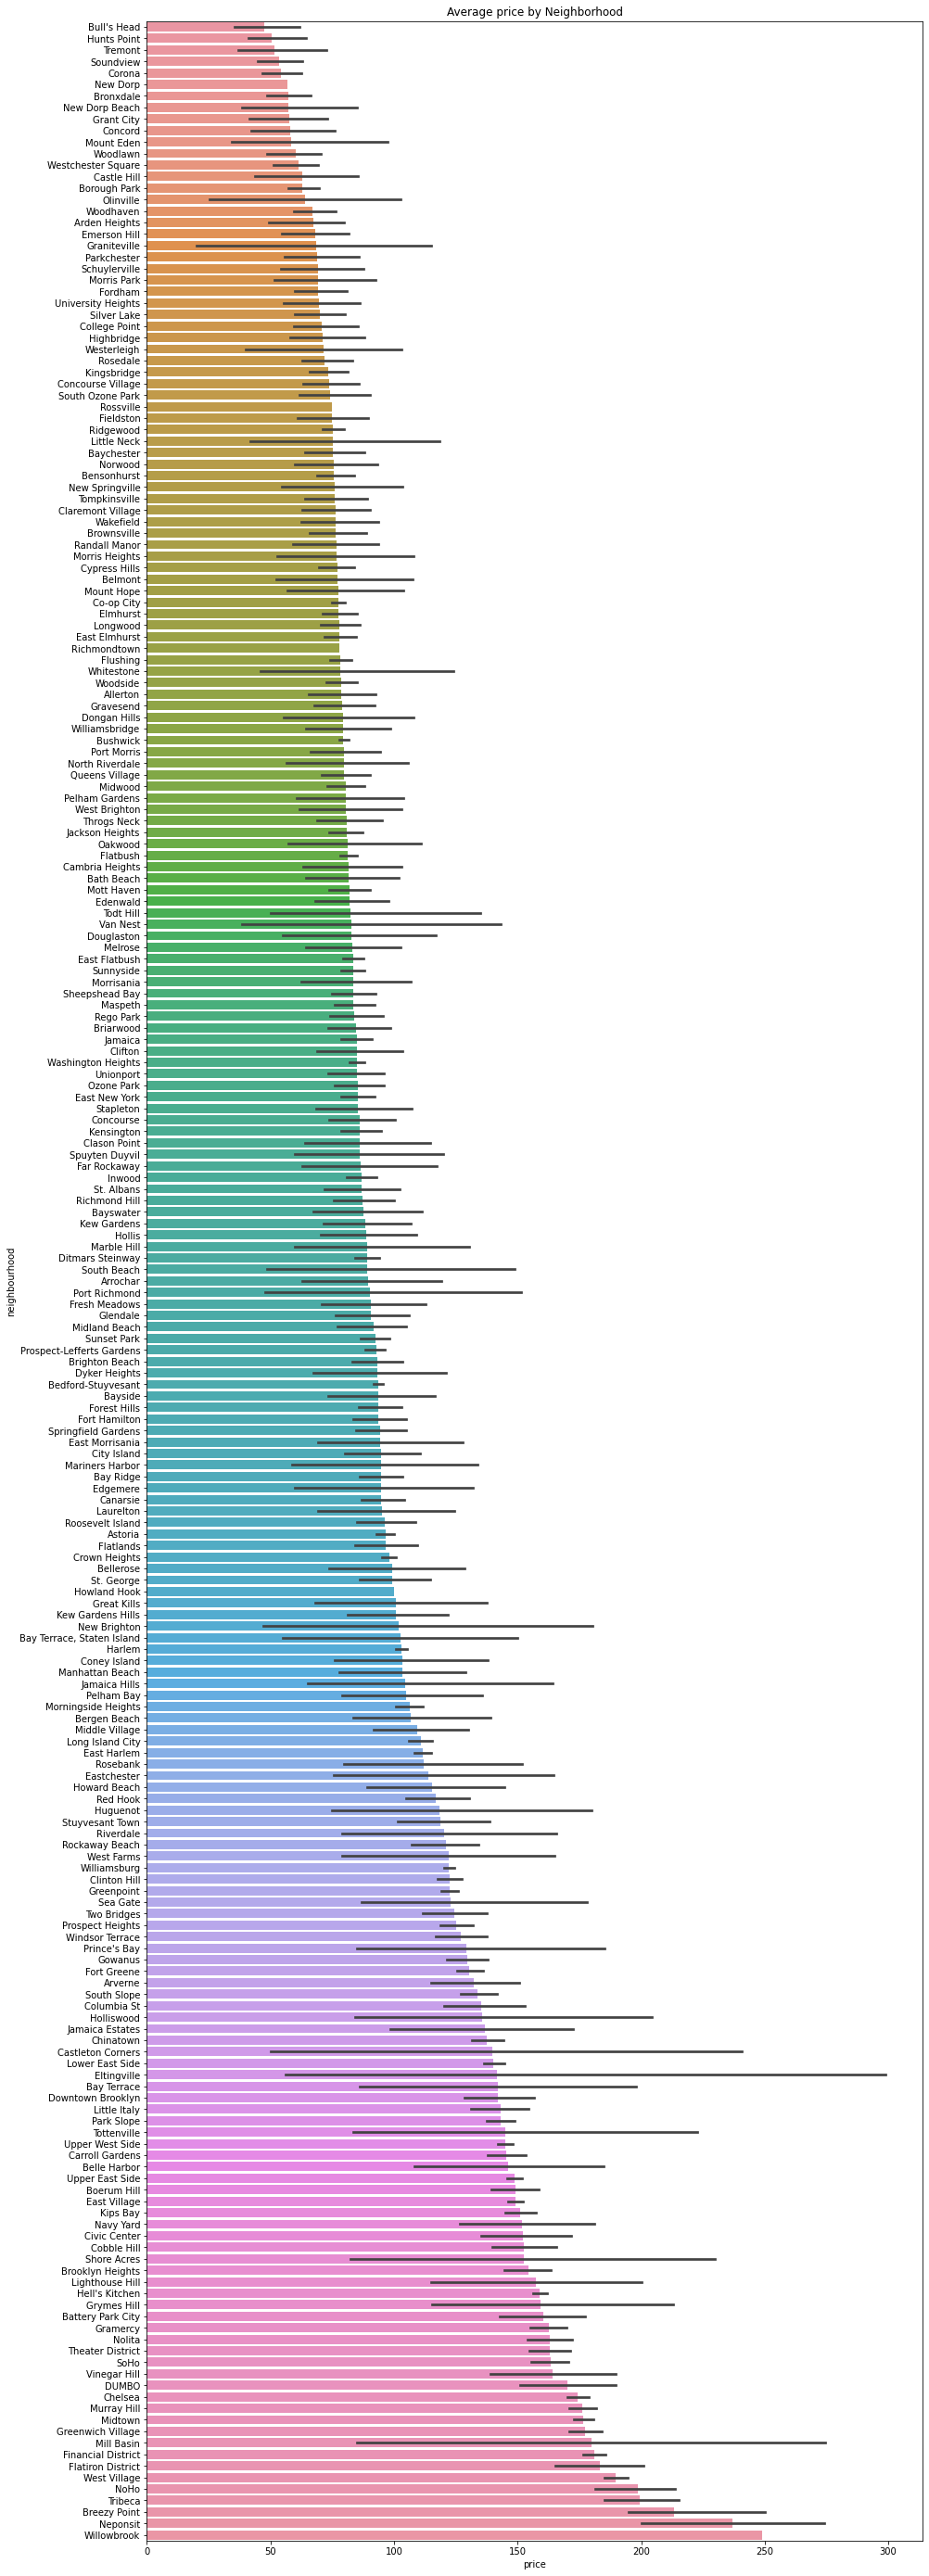

In [108]:
plt.figure(figsize=(15,50))
sns.barplot(y=df2['neighbourhood'].compute(), x=df2['price'].compute(), order=sorted_hoods2, orient='h')
plt.title("Average price by Neighborhood")
plt.show()

In [109]:
def neighbourhood_price(neighbourhood):
# if minimum_nights not in [1,2,...] return "other"
# else return minimum_nights
  if neighbourhood in ['Willowbrook', 'Neponsit', 'Breezy Point', 'Tribeca', 'NoHo', 'West Village', 'Flatiron District', 'Financial District', 'Mill Basin',
                       'Greenwhich Village', 'Midtown', 'Murray Hill', 'Chelsea', 'DUMBO', 'Vinegar Hill']:
    return 'most expensive'
  elif neighbourhood in ['SoHo', 'Theater District', 'Nolita', 'Gramercy', 'Battery Park City', 'Grymes Hill', "Hell's Kitchen",  'Lighthouse Hill', 'Brooklyn Heights',
                         'Shore Acres', 'Cobble Hill', 'Civic Center', 'Navy Yard', 'Kips Bay', 'East Village']:
    return 'expensive'
  elif neighbourhood in ['Fieldston', 'Ridgewood', 'Little Neck', 'Baychester', 'Norwood', 'Bensonhurst', 'New Springville', 'Tompkinsville', 'Claremont Village',
                         'Wakefield', 'Brownsville', 'Randall Manor', 'Morris Heights', 'Cypress Hills', 'Belmont', 'Mount Hope', 'Co-op City', 'Elmhurst',
                         'Longwood', 'East Elmhurst', 'Richmondtown', 'Flushing', 'Whitestone', 'Woodside', 'Allerton', 'Gravesend', 'Dongan Hills', 'Williamsbridge',
                         'Bushwick', 'Port Morris', 'North Riverdale', 'Queens Village', 'Midwood', 'Pelham Gardens', 'West Brighton', 'Throgs Neck', 'Jackson Heights',
                         'Oakwood', 'Flatbush', 'Cambria Heights', 'Bath Beach', 'Mott Haven', 'Edenwald', 'Todt Hill', 'Van Nest', 'Douglaston', 'Melrose',
                         'East Flatbush', 'Sunnyside', 'Morrisania', 'Sheepshead Bay', 'Maspeth', 'Rego Park', 'Briarwood', 'Jamaina', 'Clifton', 'Washington Heights',
                         'Unionport', 'Ozone Park', 'East New York', 'Stapleton', 'Concourse', 'Kensington', 'Clason Point', 'Spuyten Duyvil', 'Far Rockaway',
                         'Inwood', 'St. Albans', 'Richmond Hill', 'Bayswater', 'Kew Gardens', 'Hollis', 'Marble Hill', 'Ditmars Steinway', 'South Beach', 'Arrochar',
                         'Port Richmond', 'Fresh Meadows', 'Glendale', 'Midland Beach', 'Sunset Park', 'Prospect-Lefferts Gardens', 'Brighton Beach', 'Dyker Heights',
                         'Bedford-Stuyvesant', 'Bayside', 'Forest Hills', 'Fort Hamilton', 'Springfield Gardens', 'East Morrisania', 'City Island', 'Mariners Harbor',
                         'Bay Ridge', 'Edgemere', 'Canarsie', 'Laurelton', 'Roosevelt Island', 'Astoria', 'Flatlands', 'Crown Heights', 'Bellerose', 'St. George']:
    return 'cheap'
  elif neighbourhood in ["Bull's Head", 'Hunts Point', 'Tremont', 'Soundview', 'Corona', 'New Dorp', 'Bronxdale', 'New Dorp Beach', 'Grant City', 'Concord', 'Mount Eden',
                         'Woodlawn', 'Westchester Square', 'Castle Hill', 'Borough Park', 'Olinville', 'Woodhaven', 'Arden Heights', 'Emerson Hill', 'Graniteville',
                         'Parkchester', 'Schuylerville', 'Morris Park', 'Fordham', 'University Heights', 'Silver Lake', 'College Point', 'Highbridge', 'Westerleigh',
                         'Rosedale', 'Kingsbridge', 'Concourse Village', 'South Ozone Park', 'Rossville']:
    return 'cheapest'
  else:
    return "moderate"

# Converting the minimum nights column to categorical
df2['neighbourhood_price'] = df2['neighbourhood'].apply(neighbourhood_price)

# How many are in each group?
print(df2.groupby("neighbourhood_price")["neighbourhood"].count().compute())

neighbourhood_price
cheap             17500
cheapest            844
expensive          5170
moderate          18029
most expensive     3984
Name: neighbourhood, dtype: int64


As we would expect, roomtype is an important determinant of price. Listings for full houses and apartments are much more expensive than Private Rooms, and Private Rooms are more expensive than Shared Rooms. 

**Modeling and Data Preprocessing:**

Now I need to convert the categorical variables using pd.getdummies. 

In [114]:
# Minimum Nights
minimum_nights_df = pd.get_dummies(df1.minimum_nights_grouped, drop_first=True)
df1 = df1.merge(minimum_nights_df,left_index=True, right_index=True)

# Grouped Listing Count
grouped_listing_df = pd.get_dummies(df1.grouped_listing_count, drop_first=True)
df1 = df1.merge(grouped_listing_df,left_index=True, right_index=True)

# Neighbourhood Price
neighbourhoodprice_df = pd.get_dummies(df1.neighbourhood_price, drop_first=True)
df1 = df1.merge(neighbourhoodprice_df,left_index=True, right_index=True)

# Neighbourhood Group
neighbourhood_group_df = pd.get_dummies(df1.neighbourhood_group, drop_first=True)
df1 = df1.merge(neighbourhood_group_df,left_index=True, right_index=True)

# Room Type
room_type_df = pd.get_dummies(df1.room_type, drop_first=True)
df1 = df1.merge(room_type_df,left_index=True, right_index=True)

df1.head()

neighbourhood_group neighbourhood  ... Private room  Shared room
0            Brooklyn    Kensington  ...            1            0
1           Manhattan       Midtown  ...            0            0
2           Manhattan        Harlem  ...            1            0
3            Brooklyn  Clinton Hill  ...            0            0
4           Manhattan   East Harlem  ...            0            0

[5 rows x 47 columns]

**Preprocessing for data frame where (price <= $300)**

In [116]:
# Minimum Nights
minimum_nights_df1 = pd.get_dummies(df2.minimum_nights_grouped, drop_first=True)
df2 = df2.merge(minimum_nights_df1,left_index=True, right_index=True)

# Grouped Listing Count
grouped_listing_df1 = pd.get_dummies(df2.grouped_listing_count, drop_first=True)
df2 = df2.merge(grouped_listing_df1,left_index=True, right_index=True)

# Neighbourhood Price
neighbourhoodprice_df1 = pd.get_dummies(df2.neighbourhood_price, drop_first=True)
df2 = df2.merge(neighbourhoodprice_df1,left_index=True, right_index=True)

# Neighbourhood Group
neighbourhood_group_df1 = pd.get_dummies(df2.neighbourhood_group, drop_first=True)
df2 = df2.merge(neighbourhood_group_df1,left_index=True, right_index=True)

# Room Type
room_type_df1 = pd.get_dummies(df2.room_type, drop_first=True)
df2 = df2.merge(room_type_df1,left_index=True, right_index=True)

df2.head()

neighbourhood_group neighbourhood  ... Private room_y  Shared room_y
0            Brooklyn    Kensington  ...              1              0
1           Manhattan       Midtown  ...              0              0
2           Manhattan        Harlem  ...              1              0
3            Brooklyn  Clinton Hill  ...              0              0
4           Manhattan   East Harlem  ...              0              0

[5 rows x 66 columns]

**Regression Models (Any price):**

Since I feature engineered before modeling, I want to compare the results of models with and without features. I will be doing different Linear Regression Models to see which predictive model is best.

**Regression model with continuous variables:**

In [ ]:
X = df1[['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Private room', 'Shared room', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count']]
y = df1[['price']]

#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

print("The training set has {} observations".format(X_train.shape[0]))
print("The test set has {} observations".format(X_test.shape[0]))

# Regression Results
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()
print(results.summary())

The training set has 39107 observations
The test set has 9777 observations
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     380.4
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:40:20   Log-Likelihood:            -2.6891e+05
No. Observations:               39107   AIC:                         5.378e+05
Df Residuals:                   39097   BIC:                         5.379e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

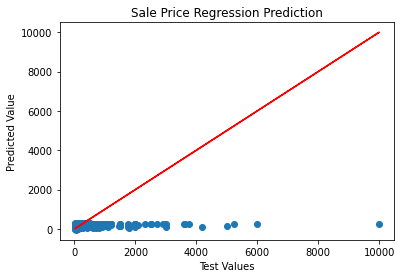

Mean absolute error of the prediction is: 72.00102015879837
Mean squared error of the prediction is: 54090.29551455877
Root mean squared error of the prediction is: 232.42562292972448


In [ ]:
#Test set
X_test = sm.add_constant(X_test)

#Predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Test Values")
plt.ylabel("Predicted Value")
plt.title("Sale Price Regression Prediction")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(np.mean(mse(y_test, y_preds))))
print("Root mean squared error of the prediction is: {}".format(np.mean(rmse(y_test, y_preds))))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

**Regression Model with Feature Engineered Controls:**

In [ ]:
#Fix name (5 listingw)
X = df1[['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Private room', 'Shared room',
         'cheapest', 'expensive', 'moderate', 'most expensive', '2-nights', '3-nights',
         '4-nights', '5-nights', '6-nights', '7-nights', '8-29 nights', '30-nights',
         '30+ nights', '2 listings', '3 listings', '4 listings', '5 listings', '6-10',
         '11-15', '16-20', '21-25', '26+ listings']]

y = df1[['price']]

#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

print("The training set has {} observations".format(X_train.shape[0]))
print("The test set has {} observations".format(X_test.shape[0]))

# Regression Results
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()
print(results.summary())

The training set has 39107 observations
The test set has 9777 observations
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     152.0
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:41:05   Log-Likelihood:            -2.6853e+05
No. Observations:               39107   AIC:                         5.371e+05
Df Residuals:                   39078   BIC:                         5.374e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

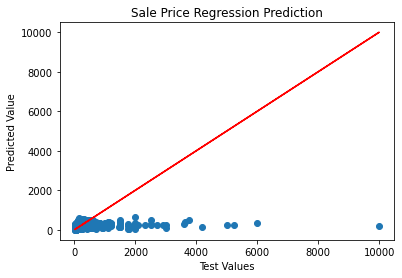

Mean absolute error of the prediction is: 71.64365695866019
Mean squared error of the prediction is: 55172.2490970327
Root mean squared error of the prediction is: 234.26281824043437


In [ ]:
#Test set
X_test = sm.add_constant(X_test)

#Predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Test Values")
plt.ylabel("Predicted Value")
plt.title("Sale Price Regression Prediction")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(np.mean(mse(y_test, y_preds))))
print("Root mean squared error of the prediction is: {}".format(np.mean(rmse(y_test, y_preds))))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

We can see that the mean absolute error of the prediction is lower for the Model with the feature engineered variables, but the Linear Regression does not do a great job at predicting price. The reason this is likely the case is that the data is skewed, now we can try log transforming price. This will remove the skew of the data and should improve the models. 

**Regression Models: Log Transformed X:**

First, Let's see what happens to price when we log-transform it. We will look at models with and without the feature engineered varaibles. 

**Log-Linear Regression Models:**

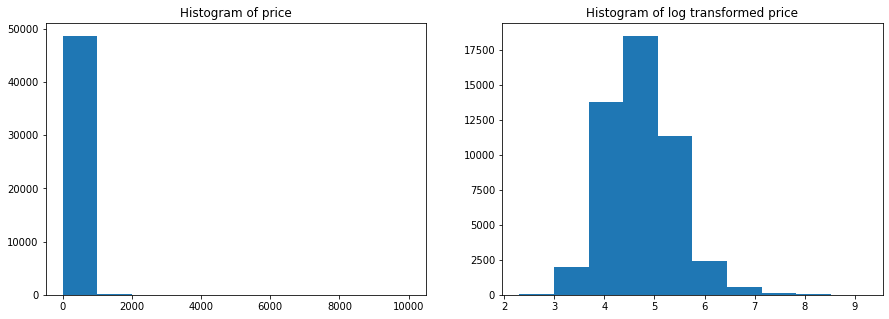

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.hist(df1["price"])
plt.title("Histogram of price")

plt.subplot(1,2,2)
plt.hist(np.log(df1["price"]))
plt.title("Histogram of log transformed price")
plt.show()

We see that by log transforming price, we see that price becomes more normal. This will likely help with our models. 

In [ ]:
df1['log_price'] = np.log(df1["price"])
df1.head()

neighbourhood_group neighbourhood  ... Shared room  log_price
0            Brooklyn    Kensington  ...           0   5.003946
1           Manhattan       Midtown  ...           0   5.416100
2           Manhattan        Harlem  ...           0   5.010635
3            Brooklyn  Clinton Hill  ...           0   4.488636
4           Manhattan   East Harlem  ...           0   4.382027

[5 rows x 39 columns]

In [ ]:
X = df1[['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Private room', 'Shared room', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count']]
y = df1[['log_price']]

#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

print("The training set has {} observations".format(X_train.shape[0]))
print("The test set has {} observations".format(X_test.shape[0]))

# Regression Results
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()
print(results.summary())

The training set has 39107 observations
The test set has 9777 observations
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     3630.
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:41:52   Log-Likelihood:                -29591.
No. Observations:               39107   AIC:                         5.920e+04
Df Residuals:                   39097   BIC:                         5.929e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

As we can see, Log Transforming the price led to a higher R-score. Let's see if our predictions improved:

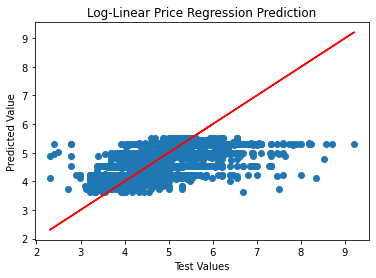

Mean absolute error of the prediction is: 0.368610020959973
Mean squared error of the prediction is: 0.70851036744396
Root mean squared error of the prediction is: 0.8359146916105589


In [ ]:
#Test set
X_test = sm.add_constant(X_test)

#Predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Test Values")
plt.ylabel("Predicted Value")
plt.title("Log-Linear Price Regression Prediction")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))

#TODO Not sure why it is not working.
print("Mean squared error of the prediction is: {}".format(np.mean(mse(y_test, y_preds))))
print("Root mean squared error of the prediction is: {}".format(np.mean(rmse(y_test, y_preds))))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [ ]:
y_preds = results.predict(X_test)
y_preds

21798    4.962840
11696    4.214020
18620    5.347509
14034    5.313213
48157    4.990213
           ...   
7537     4.972393
48728    5.319053
30871    5.322342
8742     4.541875
43371    5.316360
Length: 9777, dtype: float64

In [ ]:
# Transforming back to have in terms of money

y_preds_e = np.exp(y_preds)
y_preds_e

21798    142.999361
11696     67.627880
18620    210.084331
14034    203.001473
48157    146.967689
            ...    
7537     144.371954
48728    204.190480
30871    204.863031
8742      93.866598
43371    203.641373
Length: 9777, dtype: float64

In [ ]:
y_test
y_test_e = np.exp(y_test)
y_test_e

log_price
21798      385.0
11696       55.0
18620      133.0
14034      165.0
48157      250.0
...          ...
7537       128.0
48728      178.0
30871      269.0
8742       100.0
43371      260.0

[9777 rows x 1 columns]

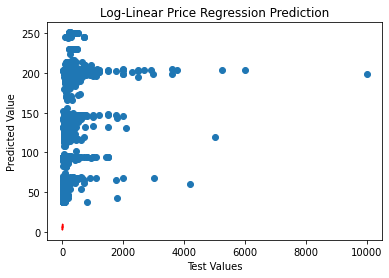

Mean absolute error of the prediction is: 63.344142626845645
Mean squared error of the prediction is: 2.0309636146475674
Root mean squared error of the prediction is: 0.8359146916105589


In [ ]:
#Test set
X_test = sm.add_constant(X_test)

#Predictions
y_preds = results.predict(X_test)

plt.scatter(y_test_e, y_preds_e)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Test Values")
plt.ylabel("Predicted Value")
plt.title("Log-Linear Price Regression Prediction")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test_e, y_preds_e)))
print("Mean squared error of the prediction is: {}".format(np.exp(np.mean(mse(y_test, y_preds)))))
print("Root mean squared error of the prediction is: {}".format(np.mean(rmse(y_test, y_preds))))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test) * 100)))

**Log Linear Regression Results with Feature Engineered Variables:**

In [ ]:
X = df1[['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Private room', 'Shared room',
         'cheapest', 'expensive', 'moderate', 'most expensive', '2-nights', '3-nights',
         '4-nights', '5-nights', '6-nights', '7-nights', '8-29 nights', '30-nights',
         '30+ nights', '2 listings', '3 listings', '4 listings', '5 listings', '6-10',
         '11-15', '16-20', '21-25', '26+ listings']]
y = df1[['log_price']]

#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

print("The training set has {} observations".format(X_train.shape[0]))
print("The test set has {} observations".format(X_test.shape[0]))

# Regression Results
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()
print(results.summary())

The training set has 39107 observations
The test set has 9777 observations
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     1316.
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:44:03   Log-Likelihood:                -28482.
No. Observations:               39107   AIC:                         5.702e+04
Df Residuals:                   39078   BIC:                         5.727e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

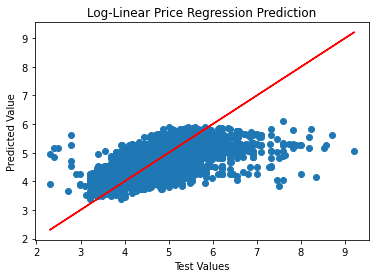

Mean absolute error of the prediction is: 0.36102747731214463
Mean squared error of the prediction is: 0.724112658636527
Root mean squared error of the prediction is: 0.8424286148039337


In [ ]:
#Test set
X_test = sm.add_constant(X_test)

#Predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Test Values")
plt.ylabel("Predicted Value")
plt.title("Log-Linear Price Regression Prediction")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(np.mean(mse(y_test, y_preds))))
print("Root mean squared error of the prediction is: {}".format(np.mean(rmse(y_test, y_preds))))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

We want to look at the metrics in terms of Dollars:

In [ ]:
y_preds = results.predict(X_test)
y_preds

21798    5.019579
11696    4.093714
18620    5.226144
14034    5.240348
48157    5.019579
           ...   
7537     4.983749
48728    5.284969
30871    5.884222
8742     4.514477
43371    5.289161
Length: 9777, dtype: float64

In [ ]:
# Transforming back to have in terms of money

y_preds_e = np.exp(y_preds)
y_preds_e

21798    151.347616
11696     59.962198
18620    186.073979
14034    188.735829
48157    151.347616
            ...    
7537     146.020760
48728    197.347979
30871    359.323023
8742      91.329755
43371    198.177175
Length: 9777, dtype: float64

In [ ]:
y_test
y_test_e = np.exp(y_test)
y_test_e

log_price
21798      385.0
11696       55.0
18620      133.0
14034      165.0
48157      250.0
...          ...
7537       128.0
48728      178.0
30871      269.0
8742       100.0
43371      260.0

[9777 rows x 1 columns]

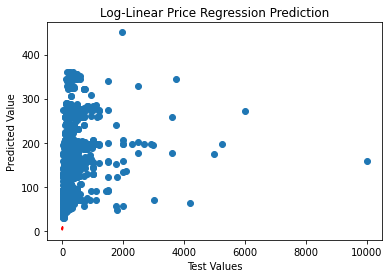

Mean absolute error of the prediction is: 62.55358184889525
Mean squared error of the prediction is: 2.062899791275173
Root mean squared error of the prediction is: 0.8424286148039337


In [ ]:
#Test set
X_test = sm.add_constant(X_test)

#Predictions
y_preds = results.predict(X_test)

plt.scatter(y_test_e, y_preds_e)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Test Values")
plt.ylabel("Predicted Value")
plt.title("Log-Linear Price Regression Prediction")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test_e, y_preds_e)))
print("Mean squared error of the prediction is: {}".format(np.exp(np.mean(mse(y_test, y_preds)))))
print("Root mean squared error of the prediction is: {}".format(np.mean(rmse(y_test, y_preds))))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test) * 100)))

We see that the model with the feature engineered variables is slightly better than the model without. However, both regression models have limitations due to the extreme outliers. It will be easier to compare these models after reducing outliers

**Regression Models (price <= $300)**

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45527 entries, 0 to 48894
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   neighbourhood_group             45527 non-null  object
 1   neighbourhood                   45527 non-null  object
 2   room_type                       45527 non-null  object
 3   price                           45527 non-null  int64 
 4   minimum_nights                  45527 non-null  int64 
 5   number_of_reviews               45527 non-null  int64 
 6   calculated_host_listings_count  45527 non-null  int64 
 7   minimum_nights_grouped          45527 non-null  object
 8   grouped_listing_count           45527 non-null  object
 9   neighbourhood_price             45527 non-null  object
 10  2-nights                        45527 non-null  uint8 
 11  3-nights                        45527 non-null  uint8 
 12  30+ nights                      45527 non-null

**Linear Regression Models:**

In [ ]:
X = df2[['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Private room', 'Shared room', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count']]
y = df2[['price']]

#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

print("The training set has {} observations".format(X_train.shape[0]))
print("The test set has {} observations".format(X_test.shape[0]))

# Regression Results
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()
print(results.summary())

The training set has 36421 observations
The test set has 9106 observations
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     3449.
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:45:32   Log-Likelihood:            -1.9300e+05
No. Observations:               36421   AIC:                         3.860e+05
Df Residuals:                   36411   BIC:                         3.861e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

We see the immediate improvements in our R-squared for our Linear Regression Model. This is because our previous model was limited and not able to predict high prices well

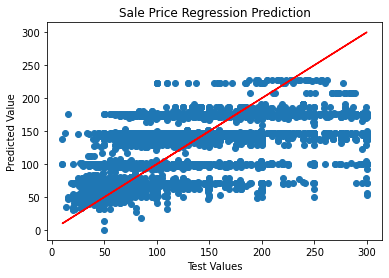

Mean absolute error of the prediction is: 36.16384007113095
Mean squared error of the prediction is: 6351.075038958101
Root mean squared error of the prediction is: 79.13802550937321


In [ ]:
#Test set
X_test = sm.add_constant(X_test)

#Predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Test Values")
plt.ylabel("Predicted Value")
plt.title("Sale Price Regression Prediction")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(np.mean(mse(y_test, y_preds))))
print("Root mean squared error of the prediction is: {}".format(np.mean(rmse(y_test, y_preds))))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

**Linear Regression with Feature Engineered Variables:**

In [ ]:
X = df2[['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Private room', 'Shared room',
         'cheapest', 'expensive', 'moderate', 'most expensive', '2-nights', '3-nights',
         '4-nights', '5-nights', '6-nights', '7-nights', '8-29 nights', '30-nights',
         '30+ nights', '2 listings', '3 listings', '4 listings', '5 listings', '6-10',
         '11-15', '16-20', '21-25', '26+ listings']]

y = df2[['price']]

#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

print("The training set has {} observations".format(X_train.shape[0]))
print("The test set has {} observations".format(X_test.shape[0]))

# Regression Results
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()
print(results.summary())

The training set has 36421 observations
The test set has 9106 observations
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     1366.
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:46:50   Log-Likelihood:            -1.9115e+05
No. Observations:               36421   AIC:                         3.824e+05
Df Residuals:                   36392   BIC:                         3.826e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

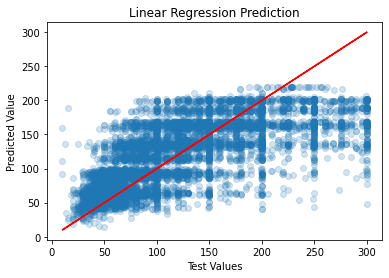

Mean absolute error of the prediction is: 34.0301416840894
Mean squared error of the prediction is: 6574.489564870021
Root mean squared error of the prediction is: 80.23599107816317


In [ ]:
#Test set
X_test = sm.add_constant(X_test)

#Predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds, alpha=0.2)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Test Values")
plt.ylabel("Predicted Value")
plt.title("Linear Regression Prediction")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(np.mean(mse(y_test, y_preds))))
print("Root mean squared error of the prediction is: {}".format(np.mean(rmse(y_test, y_preds))))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

**Log-Linear Regression Models:**

In [ ]:
df2['log_price'] = np.log(df2["price"])
df2.head()

neighbourhood_group neighbourhood  ... Shared room  log_price
0            Brooklyn    Kensington  ...           0   5.003946
1           Manhattan       Midtown  ...           0   5.416100
2           Manhattan        Harlem  ...           0   5.010635
3            Brooklyn  Clinton Hill  ...           0   4.488636
4           Manhattan   East Harlem  ...           0   4.382027

[5 rows x 39 columns]

In [ ]:
X = df2[['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Private room', 'Shared room', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count']]
y = df2[['log_price']]

#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

print("The training set has {} observations".format(X_train.shape[0]))
print("The test set has {} observations".format(X_test.shape[0]))

# Regression Results
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()
print(results.summary())

The training set has 36421 observations
The test set has 9106 observations
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     4346.
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:47:20   Log-Likelihood:                -18029.
No. Observations:               36421   AIC:                         3.608e+04
Df Residuals:                   36411   BIC:                         3.616e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

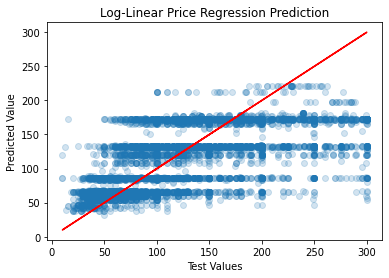

Mean absolute error of the prediction is: 35.366959433274424
Mean squared error of the prediction is: 1.6461911737859098
Root mean squared error of the prediction is: 0.7002245998158454


In [ ]:
X_test = sm.add_constant(X_test)
y_preds = results.predict(X_test)
y_preds

# Transforming back to money terms
y_preds_e = np.exp(y_preds)
y_test_e = np.exp(y_test)

# Regression Results
plt.scatter(y_test_e, y_preds_e, alpha=0.2)
plt.plot(y_test_e, y_test_e, color="red")
plt.xlabel("Test Values")
plt.ylabel("Predicted Value")
plt.title("Log-Linear Price Regression Prediction")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test_e, y_preds_e)))
print("Mean squared error of the prediction is: {}".format(np.exp(np.mean(mse(y_test, y_preds)))))
print("Root mean squared error of the prediction is: {}".format(np.mean(rmse(y_test, y_preds))))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test) * 100)))

**Log-Linear Regression Models with Feature Engineered Variables:**

In [ ]:
#Fix name (5 listingw)
X = df2[['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Private room', 'Shared room',
         'cheapest', 'expensive', 'moderate', 'most expensive', '2-nights', '3-nights',
         '4-nights', '5-nights', '6-nights', '7-nights', '8-29 nights', '30-nights',
         '30+ nights', '2 listings', '3 listings', '4 listings', '5 listings', '6-10',
         '11-15', '16-20', '21-25', '26+ listings']]
y = df2[['log_price']]

#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

print("The training set has {} observations".format(X_train.shape[0]))
print("The test set has {} observations".format(X_test.shape[0]))

# Regression Results
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()
print(results.summary())

The training set has 36421 observations
The test set has 9106 observations
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     1779.
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:47:41   Log-Likelihood:                -15611.
No. Observations:               36421   AIC:                         3.128e+04
Df Residuals:                   36392   BIC:                         3.153e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

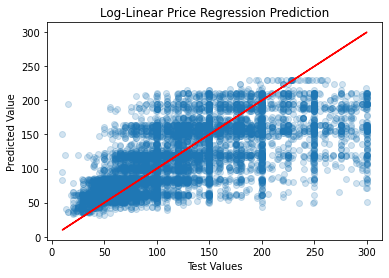

Mean absolute error of the prediction is: 32.99594054862934
Mean squared error of the prediction is: 1.6777432644162147
Root mean squared error of the prediction is: 0.7103770019540253


In [ ]:
X_test = sm.add_constant(X_test)
y_preds = results.predict(X_test)
y_preds

# Transforming back to money terms
y_preds_e = np.exp(y_preds)
y_test_e = np.exp(y_test)

# Regression Results
plt.scatter(y_test_e, y_preds_e, alpha=0.2)
plt.plot(y_test_e, y_test_e, color="red")
plt.xlabel("Test Values")
plt.ylabel("Predicted Value")
plt.title("Log-Linear Price Regression Prediction")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test_e, y_preds_e)))
print("Mean squared error of the prediction is: {}".format(np.exp(np.mean(mse(y_test, y_preds)))))
print("Root mean squared error of the prediction is: {}".format(np.mean(rmse(y_test, y_preds))))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test) * 100)))

Comparing both models. The model with the feature engineered variables has the higher R-score and the smalled Mean Absolute Error. This means that our actual predictions are on average more accurate for the Model with our feature engineered variables

**Log-Log Regression:**

One way that we dealt with the skew in the data was by doing a discretization transform of the variables. Now I want to see how well log transforming the numerical variables has on our predictions

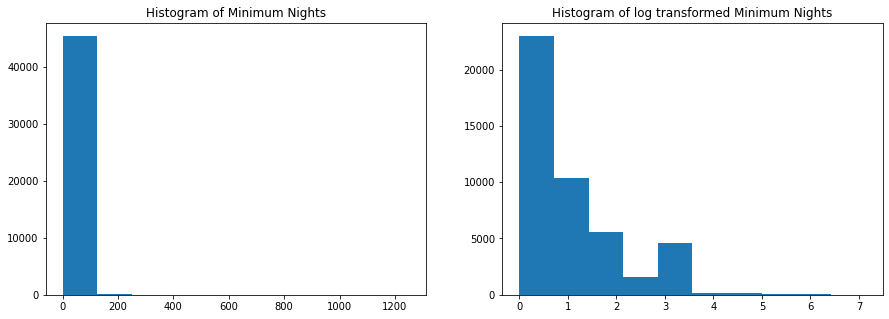

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.hist(df2["minimum_nights"])
plt.title("Histogram of Minimum Nights")

plt.subplot(1,2,2)
plt.hist(np.log(df2["minimum_nights"]))
plt.title("Histogram of log transformed Minimum Nights")
plt.show()

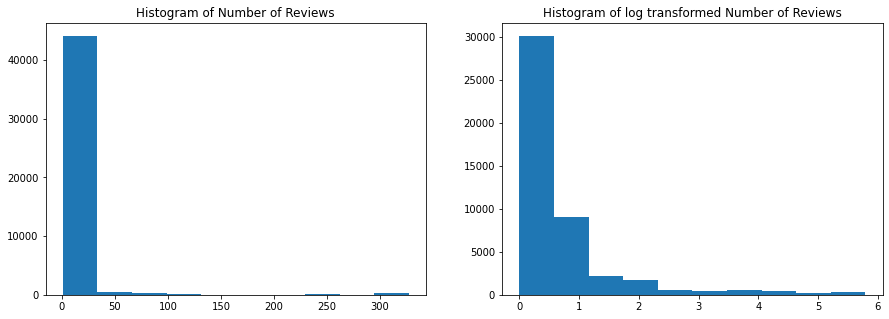

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.hist(df2["calculated_host_listings_count"])
plt.title("Histogram of Number of Reviews")

plt.subplot(1,2,2)
plt.hist(np.log(df2["calculated_host_listings_count"]))
plt.title("Histogram of log transformed Number of Reviews")
plt.show()

We see that Log Transforming does not always remove the skew. However, the skew was reduced and our prediction may be better now. Let's see

In [ ]:
# Log Transforming the variables
df2['log_min_nights'] = np.log(df2["minimum_nights"])
df2['log_host_listings_count'] = np.log(df2["calculated_host_listings_count"])

In [ ]:
X = df2[['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Private room', 'Shared room', 'log_min_nights', 'log_host_listings_count']]
y = df2[['log_price']]

#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

print("The training set has {} observations".format(X_train.shape[0]))
print("The test set has {} observations".format(X_test.shape[0]))

# Regression Results
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()
print(results.summary())

The training set has 36421 observations
The test set has 9106 observations
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     4991.
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:51:12   Log-Likelihood:                -17834.
No. Observations:               36421   AIC:                         3.569e+04
Df Residuals:                   36412   BIC:                         3.576e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

There were many places with 0 number of reviews, I have dropped the variable from the regression. 

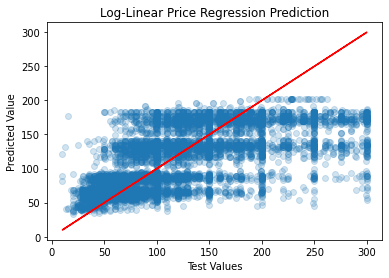

Mean absolute error of the prediction is: 35.265174216847086
Mean squared error of the prediction is: 1.649151351563747
Root mean squared error of the prediction is: 0.7012244575969305


In [ ]:
X_test = sm.add_constant(X_test)
y_preds = results.predict(X_test)
y_preds

# Transforming back to money terms
y_preds_e = np.exp(y_preds)
y_test_e = np.exp(y_test)

# Regression Results
plt.scatter(y_test_e, y_preds_e, alpha=0.2)
plt.plot(y_test_e, y_test_e, color="red")
plt.xlabel("Test Values")
plt.ylabel("Predicted Value")
plt.title("Log-Linear Price Regression Prediction")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test_e, y_preds_e)))
print("Mean squared error of the prediction is: {}".format(np.exp(np.mean(mse(y_test, y_preds)))))
print("Root mean squared error of the prediction is: {}".format(np.mean(rmse(y_test, y_preds))))
#print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test) * 100)))

We can see that there was value added by doing a disctretization transform of the variables rather than log transforming them. Now that we have predicted prices with a Regression Model, let's look at a different model whose results are not as interpretative:

**Predicting Prices Using Random Forest Model:**

We will be using a Random Forest Model using the dataframe with (price <= $300). Random Forest Models are an Ensemble modeling technique that uses a series of decision trees to average out results and make predictions. A single Decision Tree has the advantage that we get to see how the decisions are made and the results are more interpretable. Random Forests are different because they are based of many Decision Trees and the results are not interpretable. However, the results are more accurate.

**The data frame may be adjusted for the analysis**

**Decision Tree:**

First we will look at a decision tree

In [ ]:
from sklearn import tree

# This will let us use nice visualizations of the trees
from IPython.display import Image

# Packages for rendering the tree
import pydotplus
import graphviz

In [ ]:
df3 = df2.copy()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45527 entries, 0 to 48894
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             45527 non-null  object 
 1   neighbourhood                   45527 non-null  object 
 2   room_type                       45527 non-null  object 
 3   price                           45527 non-null  int64  
 4   minimum_nights                  45527 non-null  int64  
 5   number_of_reviews               45527 non-null  int64  
 6   calculated_host_listings_count  45527 non-null  int64  
 7   minimum_nights_grouped          45527 non-null  object 
 8   grouped_listing_count           45527 non-null  object 
 9   neighbourhood_price             45527 non-null  object 
 10  2-nights                        45527 non-null  uint8  
 11  3-nights                        45527 non-null  uint8  
 12  30+ nights                      

In [ ]:
# Dropping categorical Variables
df3 = df3.drop(['neighbourhood_group', 'neighbourhood', 'room_type', 'minimum_nights_grouped', 'grouped_listing_count', 'neighbourhood_price'], axis=1)
df3 = df3.drop(['log_price', 'log_min_nights', 'log_host_listings_count'], axis=1)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45527 entries, 0 to 48894
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   price                           45527 non-null  int64
 1   minimum_nights                  45527 non-null  int64
 2   number_of_reviews               45527 non-null  int64
 3   calculated_host_listings_count  45527 non-null  int64
 4   2-nights                        45527 non-null  uint8
 5   3-nights                        45527 non-null  uint8
 6   30+ nights                      45527 non-null  uint8
 7   30-nights                       45527 non-null  uint8
 8   4-nights                        45527 non-null  uint8
 9   5-nights                        45527 non-null  uint8
 10  6-nights                        45527 non-null  uint8
 11  7-nights                        45527 non-null  uint8
 12  8-29 nights                     45527 non-null  uint8
 13  1

In [ ]:
#Defining X and y
X = df3.drop(['price'], axis=1)
y = df3['price']


# Train Test Split (This will let us score)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=44
)

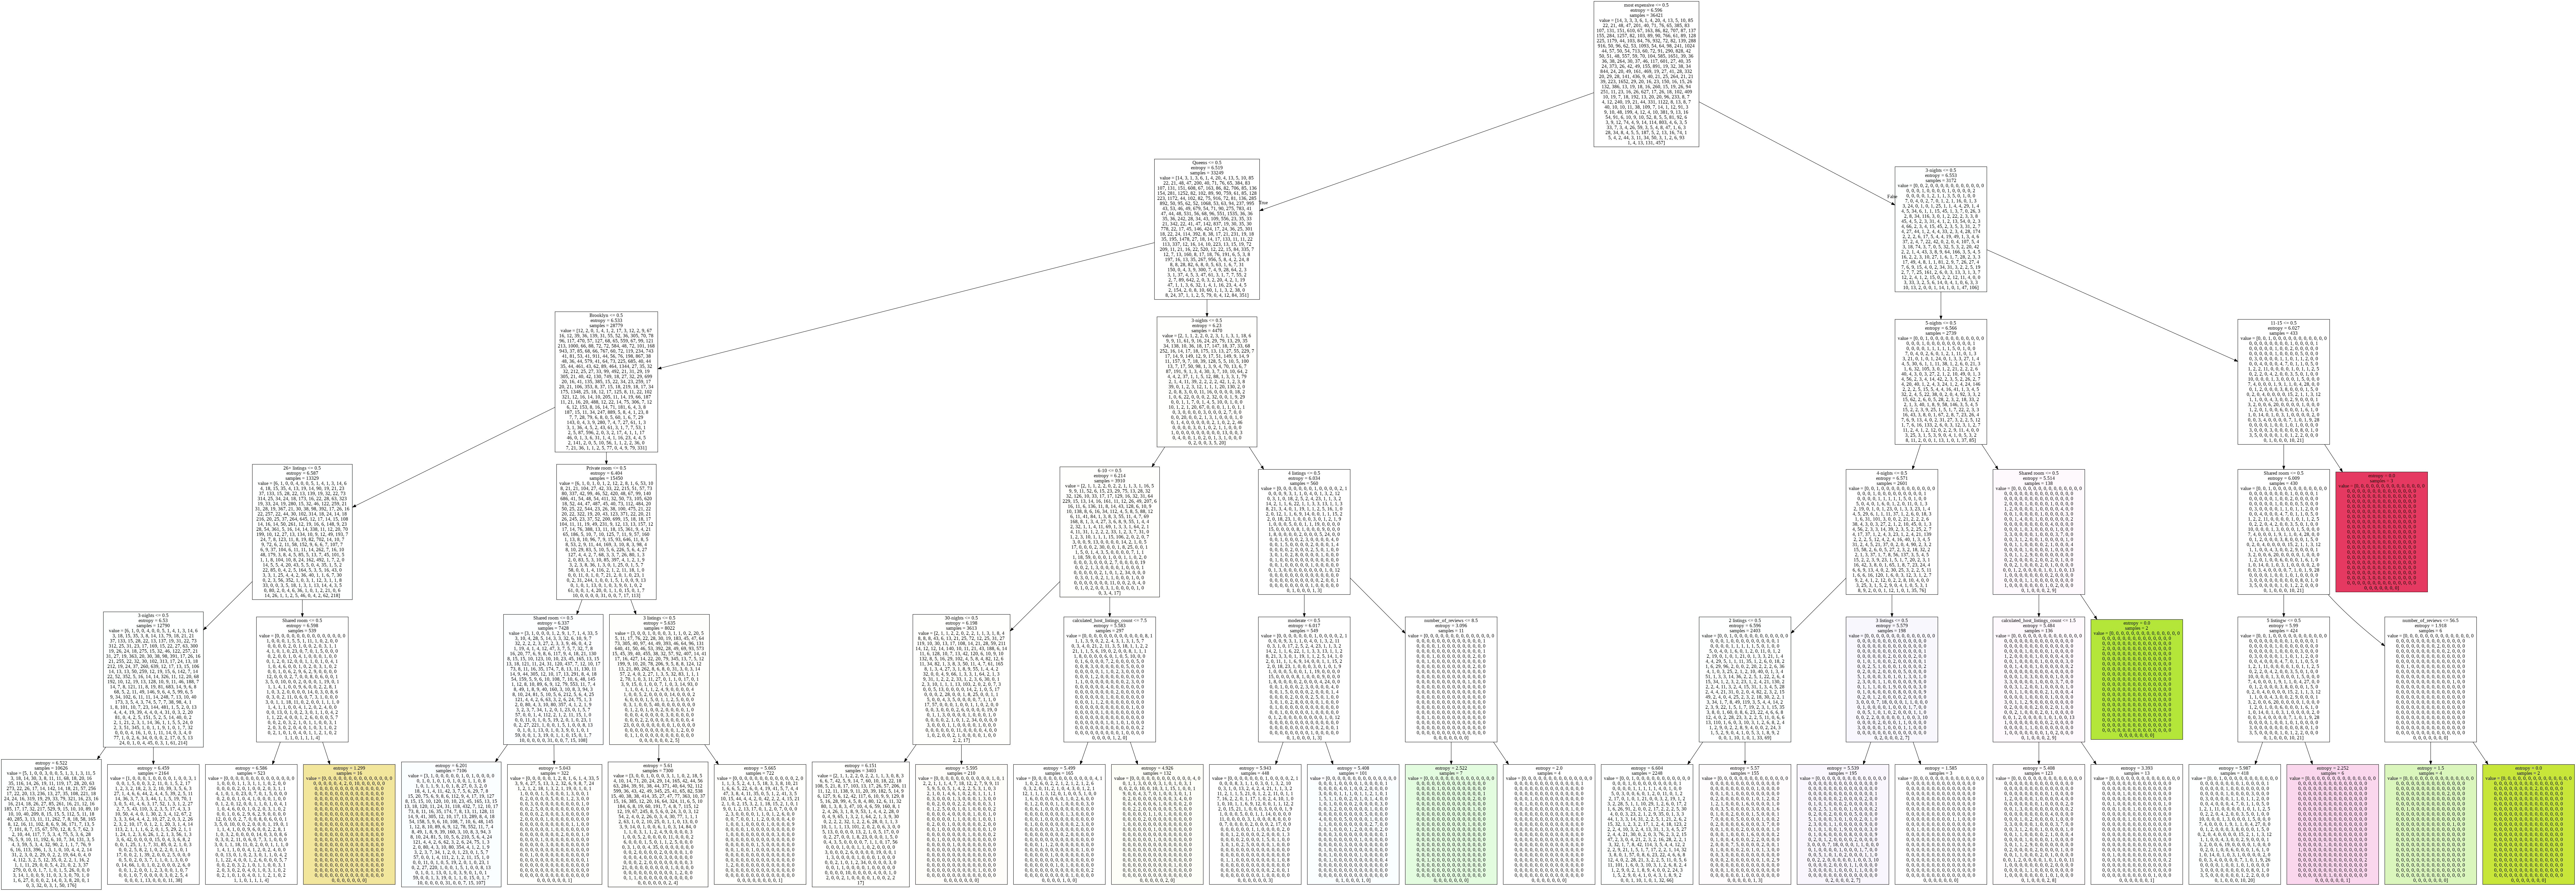

In [ ]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(  
    criterion='entropy',
    max_features=2,
    max_depth=5,
    random_state = 44
)
decision_tree.fit(X_train, y_train)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=df3.columns.drop('price'),
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


The results may be a bit overwhelming but what the Decision Tree is doing is finding groups in the data and separating them depending on what reduces the most entropy (or chaos/disorder)

In [ ]:
# Training Accuracy Score
decision_tree.score(X_train, y_train)

0.06674720628209001

In [ ]:
# Test Accuracy Score
decision_tree.score(X_test, y_test)

0.06039973643751373

**Random Forest Model:**

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Defining X and y
X = df3.drop(['price'], axis=1)
y = df3['price']


# Train Test Split (This will let us score)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=44
)

In [ ]:
selector = SelectFromModel(RandomForestClassifier(), max_features=3)
selector.fit(X_train, y_train)
X_train.loc[:, selector.get_support()].head()

minimum_nights  number_of_reviews  calculated_host_listings_count
6826                6                  8                               1
25653               2                  1                               1
22377               1                129                               3
23774               5                  1                               1
44456               5                  1                               3

In [ ]:
# Using sklearn's GridSearchCV to choose the best parameters for the model
grid = {
    "n_estimators": [300, 400, 500],
    "max_depth": [1, 2, 3, 4, 5],
    "min_samples_leaf": [1, 10, 20],
}

model = GridSearchCV(RandomForestClassifier(), grid, cv=3, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 15.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

One of the downsides of random forest models is that they can be resource intensive and not very interpretable. However, let's see how well the model predicted.

In [ ]:
model.best_params_

{'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 500}

In [ ]:
model.score(X_train, y_train)

0.09121111446692842

In [ ]:
model.score(X_test, y_test)

0.08412036020206458

We see that the Random Forest Model did not perform well on the data. Why might this be? I believe the reason this occured is that a lot of the data is skewed. Also, the metrics used in the Linear Regression are different. We did not have an accuracy score there but we knew that prices were difficult to predict since our predictions were on average off by about $30. 